# Private Ferry & NY Waterway Deep Dive Analysis

**Comprehensive analysis of private ferry operations in the NYC metropolitan area (2013-2025)**

This notebook provides an in-depth exploration of private ferry services, with special focus on:

1. **Data Overview** - Understanding the private ferry dataset
2. **Operator Analysis** - Comparing all ferry operators
3. **NY Waterway Deep Dive** - The dominant cross-Hudson operator
4. **Cross-Hudson Commuter Analysis** - NJ → Manhattan patterns
5. **SeaStreak & Jersey Shore** - Long-distance ferry commuting
6. **Temporal Patterns** - Daily, weekly, monthly, yearly trends
7. **COVID Impact & Recovery** - Pandemic effects on ferry ridership
8. **Interactive Maps** - Terminal locations with basemaps
9. **Citi Bike Integration** - First/last mile connections
10. **NYC Ferry vs Private** - Public vs private comparison

---

## Setup & Imports

In [1]:
# Core imports
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path
from datetime import datetime, date

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Interactive maps
import folium
from folium.plugins import MarkerCluster, HeatMap

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Paths
FERRY_DIR = Path('../')
DATA_DIR = FERRY_DIR / 'data'
PRIVATE_FERRY_PATH = DATA_DIR / 'private_ferry' / 'private_ferry_daily.parquet'
CITIBIKE_STATIONS_PATH = Path('../../reference/current_stations.csv')

print(f"Private ferry data: {PRIVATE_FERRY_PATH.exists()}")
print(f"Citi Bike stations: {CITIBIKE_STATIONS_PATH.exists()}")

Private ferry data: True
Citi Bike stations: True


/Users/davidpiegaro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


---

# Part 1: Data Overview

Understanding the private ferry dataset structure and coverage.

In [2]:
# Load private ferry data
df_raw = pd.read_parquet(PRIVATE_FERRY_PATH)

print("Private Ferry Dataset")
print("="*70)
print(f"Total records: {len(df_raw):,}")
print(f"Total ridership: {df_raw['ridership'].sum():,}")
print(f"\nColumns: {list(df_raw.columns)}")
print(f"\nData types:")
print(df_raw.dtypes)

Private Ferry Dataset
Total records: 252,369
Total ridership: 137,625,733

Columns: ['date', 'day_of_week', 'holiday', 'operator', 'destination', 'origin', 'ridership']

Data types:
date           object
day_of_week    object
holiday        object
operator       object
destination    object
origin         object
ridership       int64
dtype: object


In [3]:
# Clean and prepare the data
df = df_raw.copy()

# Convert date
df['date'] = pd.to_datetime(df['date'])

# Filter out bad dates
df = df[df['date'] >= '2013-01-01']

# Add derived columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['week'] = df['date'].dt.isocalendar().week
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])
df['is_holiday'] = df['holiday'].notna()

# Season
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

df['season'] = df['month'].apply(get_season)

# Create route identifier
df['route'] = df['origin'] + ' → ' + df['destination']

print(f"Clean dataset: {len(df):,} records")
print(f"Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Years covered: {df['year'].min()} - {df['year'].max()}")

Clean dataset: 252,155 records
Date range: 2013-01-01 to 2025-10-31
Years covered: 2013 - 2025


In [4]:
# Sample of the data
df.sample(10)

,date,day_of_week,holiday,operator,destination,origin,ridership,year,month,day,quarter,week,is_weekend,is_holiday,season,route
211140,2024-07-23,Tuesday,None,NYC Ferry,Soundview,Wall St Pier 11,899,2024,7,23,3,30,False,False,Summer,Wall St Pier 11 → Soundview
185840,2023-07-07,Friday,None,NY Waterway,Pier 79,Lincoln Harbor,799,2023,7,7,3,27,False,False,Summer,Lincoln Harbor → Pier 79
204974,2024-04-24,Wednesday,None,NY Waterway,Pier 79,Hoboken 14,1706,2024,4,24,2,17,False,False,Spring,Hoboken 14 → Pier 79
68792,2017-11-24,Friday,None,NYC Ferry,Rockaway,Rockaway,664,2017,11,24,4,47,False,False,Fall,Rockaway → Rockaway
153862,2022-05-07,Saturday,None,NYC Ferry,East River,East 34th Street,336,2022,5,7,2,18,True,False,Spring,East 34th Street → East River
14467,2014-02-08,Saturday,None,Billy Bey,North Williamsburg,East River,208,2014,2,8,1,6,True,False,Winter,East River → North Williamsburg
22767,2014-09-01,Monday,None,Water Taxi,Christopher Street,Christopher Street,44,2014,9,1,3,36,False,False,Fall,Christopher Street → Christopher Street
98908,2019-07-18,Thursday,None,Liberty Landing,World Financial Center,Liberty Landing Ferry,1572,2019,7,18,3,29,False,False,Summer,Liberty Landing Ferry → World Financial Center
92492,2019-03-27,Wednesday,None,Water Taxi,Redhook / Ikea Shuttle,Red Hook IKEA,61,2019,3,27,1,13,False,False,Spring,Red Hook IKEA → Redhook / Ikea Shuttle
1208,2013-02-06,Wednesday,None,Billy Bey,Pier 11,Hoboken,2042,2013,2,6,1,6,False,False,Winter,Hoboken → Pier 11


In [5]:
# Data quality check
print("Data Quality Summary")
print("="*50)
print(f"Zero ridership records: {(df['ridership'] == 0).sum():,} ({(df['ridership'] == 0).mean()*100:.1f}%)")
print(f"Records with holidays: {df['is_holiday'].sum():,}")
print(f"\nOperators: {df['operator'].nunique()}")
print(f"Origins: {df['origin'].nunique()}")
print(f"Destinations: {df['destination'].nunique()}")
print(f"Unique routes: {df['route'].nunique()}")

Data Quality Summary
Zero ridership records: 87,452 (34.7%)
Records with holidays: 2,375

Operators: 9
Origins: 91
Destinations: 45
Unique routes: 152


In [6]:
# Create active ridership dataset (filter zero ridership for analysis)
df_active = df[df['ridership'] > 0].copy()
print(f"Active ridership records: {len(df_active):,} ({len(df_active)/len(df)*100:.1f}% of total)")
print(f"Total ridership: {df_active['ridership'].sum():,}")

Active ridership records: 164,703 (65.3% of total)
Total ridership: 137,625,733


---

# Part 2: Operator Analysis

Comparing all ferry operators in the dataset.

In [7]:
# Operator summary
operator_summary = df_active.groupby('operator').agg({
    'ridership': ['sum', 'mean', 'max'],
    'date': ['min', 'max'],
    'route': 'nunique',
    'origin': 'nunique',
    'destination': 'nunique'
}).round(1)

operator_summary.columns = ['total_ridership', 'avg_daily_route', 'max_daily', 
                            'first_date', 'last_date', 'routes', 'origins', 'destinations']
operator_summary = operator_summary.sort_values('total_ridership', ascending=False)
operator_summary['market_share'] = (operator_summary['total_ridership'] / operator_summary['total_ridership'].sum() * 100).round(1)
operator_summary['status'] = operator_summary['last_date'].apply(
    lambda x: 'Active' if x.year >= 2024 else 'Inactive'
)

print("Ferry Operator Summary (2013-2025):")
operator_summary

Ferry Operator Summary (2013-2025):


,total_ridership,avg_daily_route,max_daily,first_date,last_date,routes,origins,destinations,market_share,status
operator,,,,,,,,,,
NY Waterway,59117204,1394.8,26370,2013-01-02,2025-10-31,44,29,10,43.0,Active
NYC Ferry,30506140,552.2,14696,2017-05-03,2025-10-31,42,31,11,22.2,Active
Billy Bey,28084613,1066.7,178555,2013-01-02,2020-03-31,22,7,12,20.4,Inactive
SeaStreak,12440169,661.5,7367,2013-01-02,2025-10-31,24,9,7,9.0,Active
Water Taxi,4622077,277.4,5280,2013-01-01,2025-10-31,19,17,9,3.4,Active
Liberty Landing,2341625,598.6,4914,2013-01-02,2025-10-31,1,1,1,1.7,Active
HMS,348137,376.8,1579,2016-12-17,2017-04-30,7,1,7,0.3,Inactive
Water Tours,144596,533.6,1590,2017-04-08,2017-08-24,2,2,2,0.1,Inactive
Baseball,21172,129.1,489,2013-04-06,2016-10-02,2,2,1,0.0,Inactive


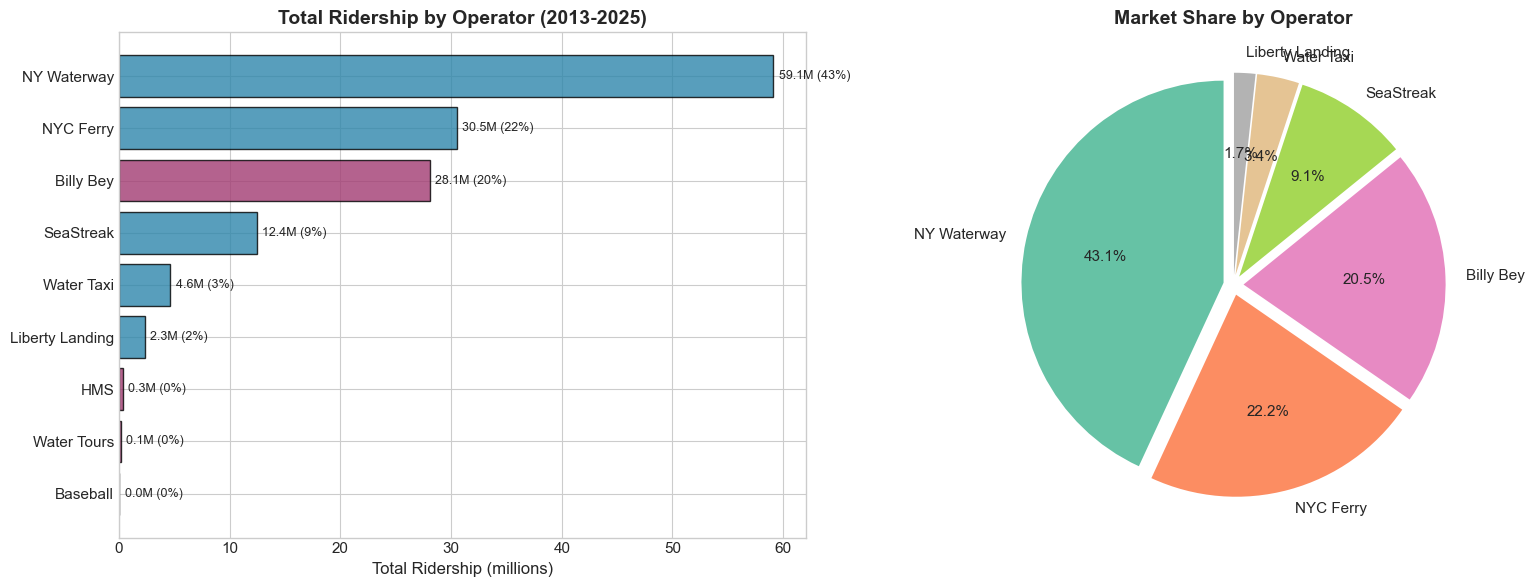


Blue = Active operators, Purple = Inactive operators


In [8]:
# Visualize operator market share
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of total ridership
op_data = operator_summary.reset_index().sort_values('total_ridership', ascending=True)
colors = ['#2E86AB' if s == 'Active' else '#A23B72' for s in op_data['status']]
axes[0].barh(op_data['operator'], op_data['total_ridership']/1e6, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Total Ridership (millions)', fontsize=12)
axes[0].set_title('Total Ridership by Operator (2013-2025)', fontsize=14, fontweight='bold')

# Add value labels
for i, (val, pct) in enumerate(zip(op_data['total_ridership'], op_data['market_share'])):
    axes[0].text(val/1e6 + 0.5, i, f'{val/1e6:.1f}M ({pct:.0f}%)', va='center', fontsize=9)

# Pie chart of market share (top operators)
top_ops = operator_summary[operator_summary['market_share'] >= 1].copy()
pie_colors = plt.cm.Set2(np.linspace(0, 1, len(top_ops)))
axes[1].pie(top_ops['total_ridership'], labels=top_ops.index, colors=pie_colors,
            autopct='%1.1f%%', startangle=90, explode=[0.05]*len(top_ops))
axes[1].set_title('Market Share by Operator', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nBlue = Active operators, Purple = Inactive operators")

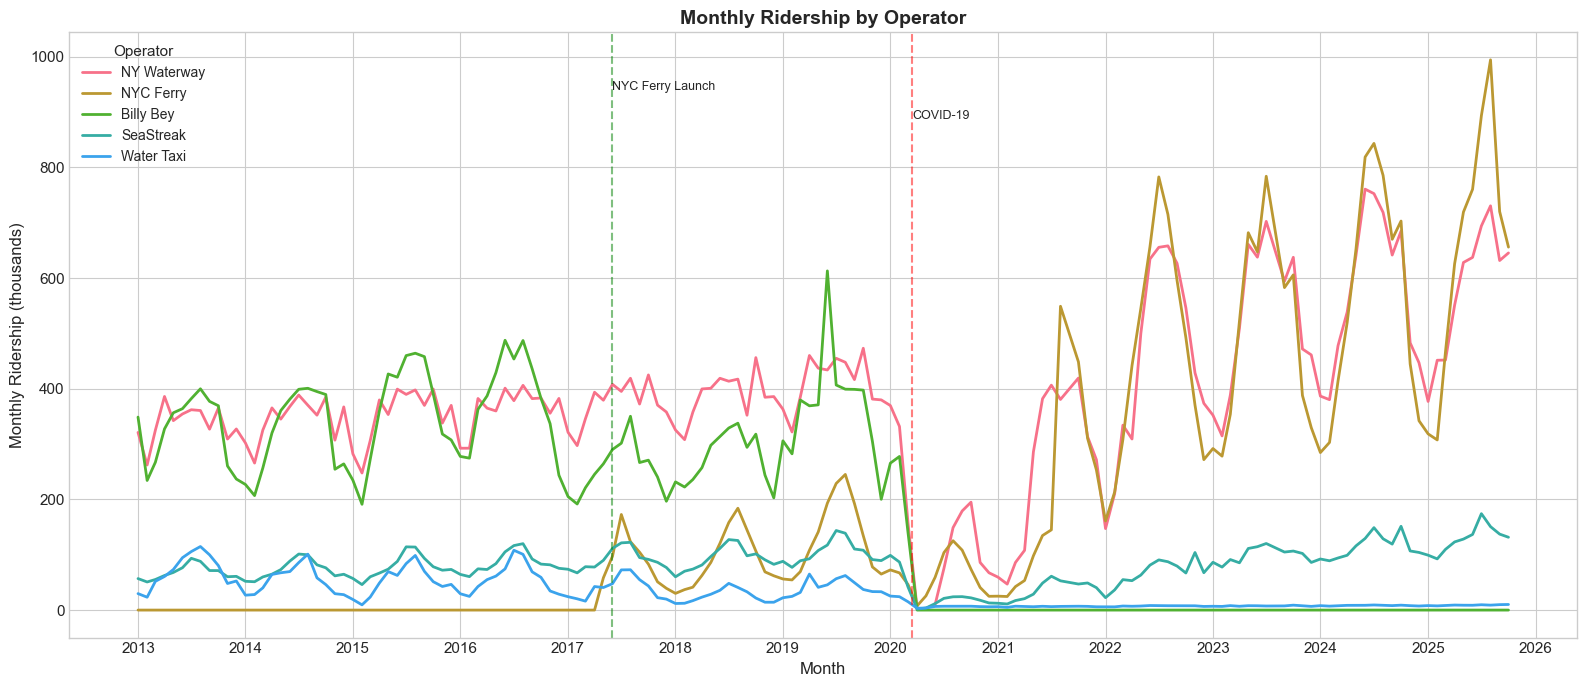

In [9]:
# Operator ridership over time
operator_monthly = df_active.groupby([df_active['date'].dt.to_period('M'), 'operator'])['ridership'].sum().unstack(fill_value=0)
operator_monthly.index = operator_monthly.index.to_timestamp()

# Plot top 5 operators
top_operators = ['NY Waterway', 'NYC Ferry', 'Billy Bey', 'SeaStreak', 'Water Taxi']

fig, ax = plt.subplots(figsize=(16, 7))
for op in top_operators:
    if op in operator_monthly.columns:
        ax.plot(operator_monthly.index, operator_monthly[op]/1e3, label=op, linewidth=2)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Ridership (thousands)', fontsize=12)
ax.set_title('Monthly Ridership by Operator', fontsize=14, fontweight='bold')
ax.legend(title='Operator', fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Mark key events
ax.axvline(x=pd.Timestamp('2017-06-01'), color='green', linestyle='--', alpha=0.5)
ax.annotate('NYC Ferry Launch', xy=(pd.Timestamp('2017-06-01'), ax.get_ylim()[1]*0.9), fontsize=9)

ax.axvline(x=pd.Timestamp('2020-03-15'), color='red', linestyle='--', alpha=0.5)
ax.annotate('COVID-19', xy=(pd.Timestamp('2020-03-15'), ax.get_ylim()[1]*0.85), fontsize=9)

plt.tight_layout()
plt.show()

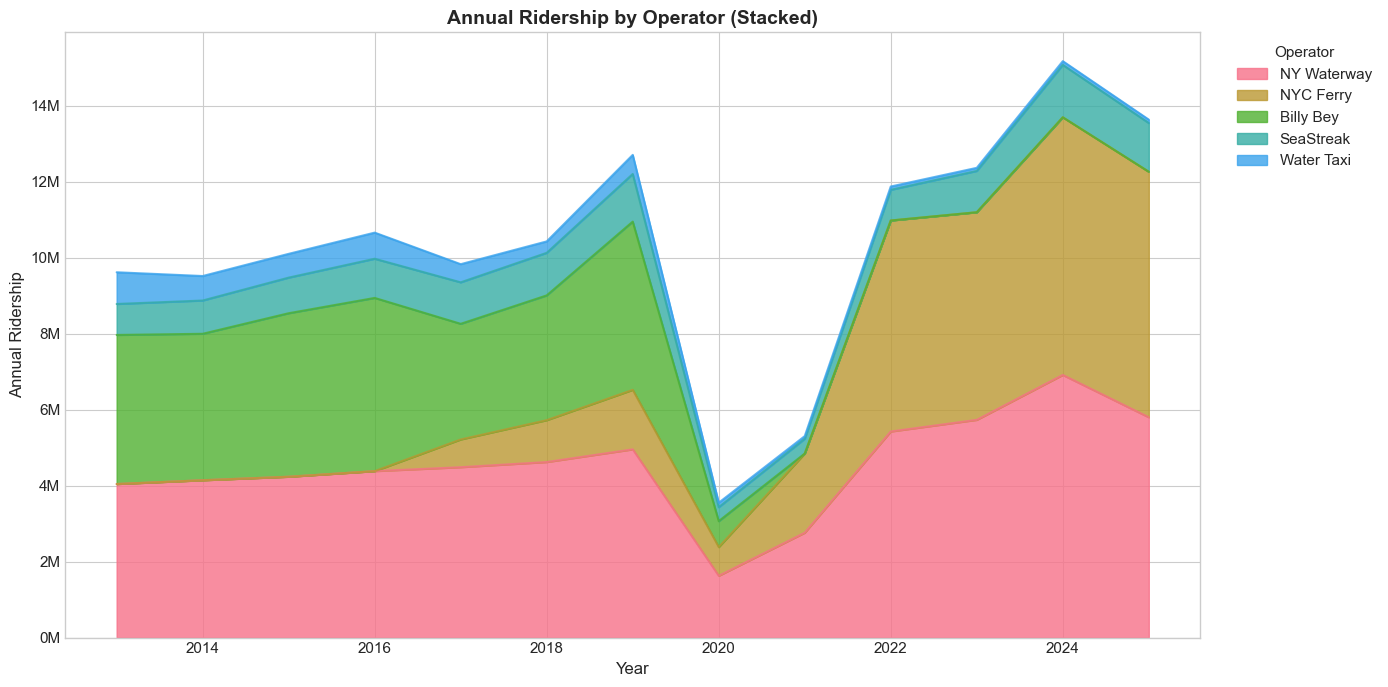

In [10]:
# Annual ridership stacked area chart
operator_yearly = df_active.groupby(['year', 'operator'])['ridership'].sum().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 7))
operator_yearly[top_operators].plot(kind='area', ax=ax, stacked=True, alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual Ridership', fontsize=12)
ax.set_title('Annual Ridership by Operator (Stacked)', fontsize=14, fontweight='bold')
ax.legend(title='Operator', bbox_to_anchor=(1.02, 1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

plt.tight_layout()
plt.show()

---

# Part 3: NY Waterway Deep Dive

NY Waterway is the largest private ferry operator, dominating cross-Hudson commuter service.

In [11]:
# Filter to NY Waterway
nyw = df_active[df_active['operator'] == 'NY Waterway'].copy()

print("NY Waterway Summary")
print("="*60)
print(f"Total records: {len(nyw):,}")
print(f"Total ridership: {nyw['ridership'].sum():,}")
print(f"Date range: {nyw['date'].min().strftime('%Y-%m-%d')} to {nyw['date'].max().strftime('%Y-%m-%d')}")
print(f"\nRoutes: {nyw['route'].nunique()}")
print(f"Origins: {nyw['origin'].nunique()}")
print(f"Destinations: {nyw['destination'].nunique()}")
print(f"\nAverage daily ridership (per route): {nyw['ridership'].mean():,.0f}")
print(f"Max daily ridership: {nyw['ridership'].max():,}")

NY Waterway Summary
Total records: 42,385
Total ridership: 59,117,204
Date range: 2013-01-02 to 2025-10-31

Routes: 44
Origins: 29
Destinations: 10

Average daily ridership (per route): 1,395
Max daily ridership: 26,370


In [12]:
# NY Waterway origin analysis
nyw_origins = nyw.groupby('origin')['ridership'].agg(['sum', 'mean', 'count']).reset_index()
nyw_origins.columns = ['origin', 'total_ridership', 'avg_daily', 'days_active']
nyw_origins = nyw_origins.sort_values('total_ridership', ascending=False)
nyw_origins['pct'] = (nyw_origins['total_ridership'] / nyw_origins['total_ridership'].sum() * 100).round(1)

print("NY Waterway: Top Origins (Departure Points)")
nyw_origins.head(15)

NY Waterway: Top Origins (Departure Points)


,origin,total_ridership,avg_daily,days_active,pct
28,Weehawken Midtown,19847638,4449.145483,4461,33.6
7,Governors Island (GI Ferry Slip),6839018,3708.795011,1844,11.6
12,Hoboken North,4563033,1886.330302,2419,7.7
16,Lincoln Harbor,4492669,1432.611288,3136,7.6
2,Belford,4059735,1697.923463,2391,6.9
18,Paulus Hook,3720631,893.094335,4166,6.3
26,Weehawken,2581430,673.299426,3834,4.4
13,Hoboken/NJT,2211834,801.098877,2761,3.7
27,Weehawken Hoboken North,2081887,843.210612,2469,3.5
4,Edgewater,2064720,716.419153,2882,3.5


In [13]:
# NY Waterway destination analysis
nyw_dests = nyw.groupby('destination')['ridership'].agg(['sum', 'mean', 'count']).reset_index()
nyw_dests.columns = ['destination', 'total_ridership', 'avg_daily', 'days_active']
nyw_dests = nyw_dests.sort_values('total_ridership', ascending=False)
nyw_dests['pct'] = (nyw_dests['total_ridership'] / nyw_dests['total_ridership'].sum() * 100).round(1)

print("NY Waterway: Destinations (Arrival Points)")
nyw_dests.head(10)

NY Waterway: Destinations (Arrival Points)


,destination,total_ridership,avg_daily,days_active,pct
4,Pier 79,34757937,1945.915183,17862,58.8
2,Pier 11,7598230,640.660202,11860,12.9
8,World Financial Center/ BPT,6242294,1013.194936,6161,10.6
0,BMB,6121389,4172.725971,1467,10.4
7,World Financial Center,1166235,949.702769,1228,2.0
6,Tours,988957,990.938878,998,1.7
9,World Financial Center/BPT,783590,985.647799,795,1.3
1,Battery Maritime Building,717629,1903.525199,377,1.2
3,Pier 6 BBP Atlantic Ave,401773,1674.054167,240,0.7
5,Redhook / Ikea Shuttle,339170,242.784538,1397,0.6


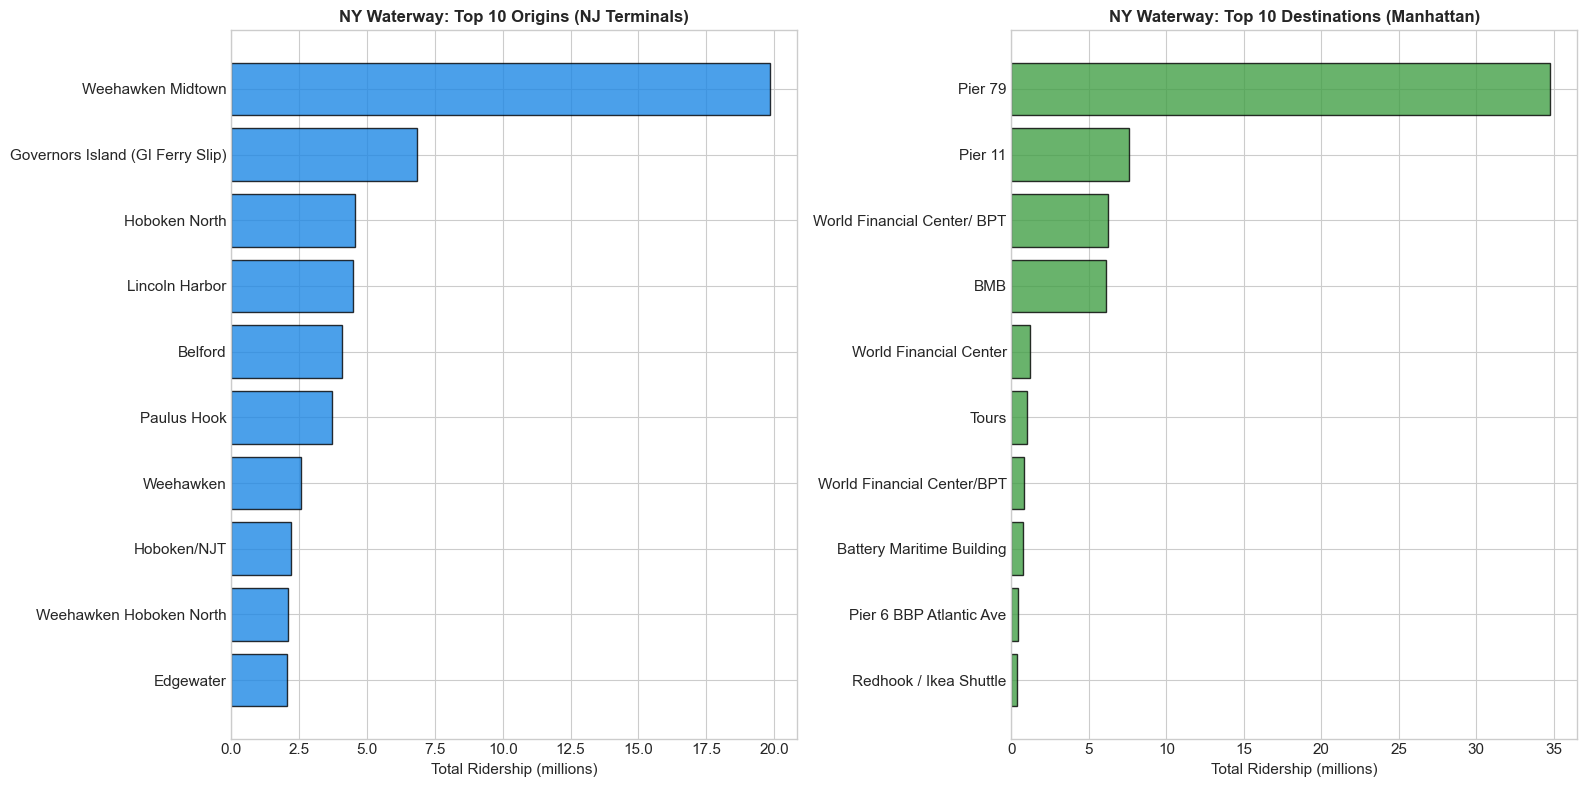

In [14]:
# Visualize NY Waterway origins and destinations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Origins
top_origins = nyw_origins.head(10)
axes[0].barh(range(len(top_origins)), top_origins['total_ridership']/1e6, 
             color='#1E88E5', edgecolor='black', alpha=0.8)
axes[0].set_yticks(range(len(top_origins)))
axes[0].set_yticklabels(top_origins['origin'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Total Ridership (millions)')
axes[0].set_title('NY Waterway: Top 10 Origins (NJ Terminals)', fontsize=12, fontweight='bold')

# Destinations
top_dests = nyw_dests.head(10)
axes[1].barh(range(len(top_dests)), top_dests['total_ridership']/1e6, 
             color='#43A047', edgecolor='black', alpha=0.8)
axes[1].set_yticks(range(len(top_dests)))
axes[1].set_yticklabels(top_dests['destination'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Total Ridership (millions)')
axes[1].set_title('NY Waterway: Top 10 Destinations (Manhattan)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
# NY Waterway top routes
nyw_routes = nyw.groupby('route')['ridership'].agg(['sum', 'mean', 'count']).reset_index()
nyw_routes.columns = ['route', 'total_ridership', 'avg_daily', 'days_active']
nyw_routes = nyw_routes.sort_values('total_ridership', ascending=False)
nyw_routes['pct'] = (nyw_routes['total_ridership'] / nyw_routes['total_ridership'].sum() * 100).round(1)

print("NY Waterway: Top 15 Routes")
nyw_routes.head(15)

NY Waterway: Top 15 Routes


,route,total_ridership,avg_daily,days_active,pct
41,Weehawken Midtown → Pier 79,19847638,4449.145483,4461,33.6
6,Governors Island (GI Ferry Slip) → BMB,6121389,4172.725971,1467,10.4
14,Hoboken North → Pier 79,4563033,1886.330302,2419,7.7
24,Lincoln Harbor → Pier 79,4492669,1432.611288,3136,7.6
2,Belford → Pier 11,4059735,1697.923463,2391,6.9
27,Paulus Hook → World Financial Center/ BPT,3200904,1726.485437,1854,5.4
42,Weehawken → Pier 11,2196720,724.511873,3032,3.7
4,Edgewater → Pier 79,2064720,716.419153,2882,3.5
20,Hoboken/NJT → World Financial Center/ BPT,1678755,1466.161572,1145,2.8
38,Weehawken Hoboken North → World Financial Center,1166235,949.702769,1228,2.0


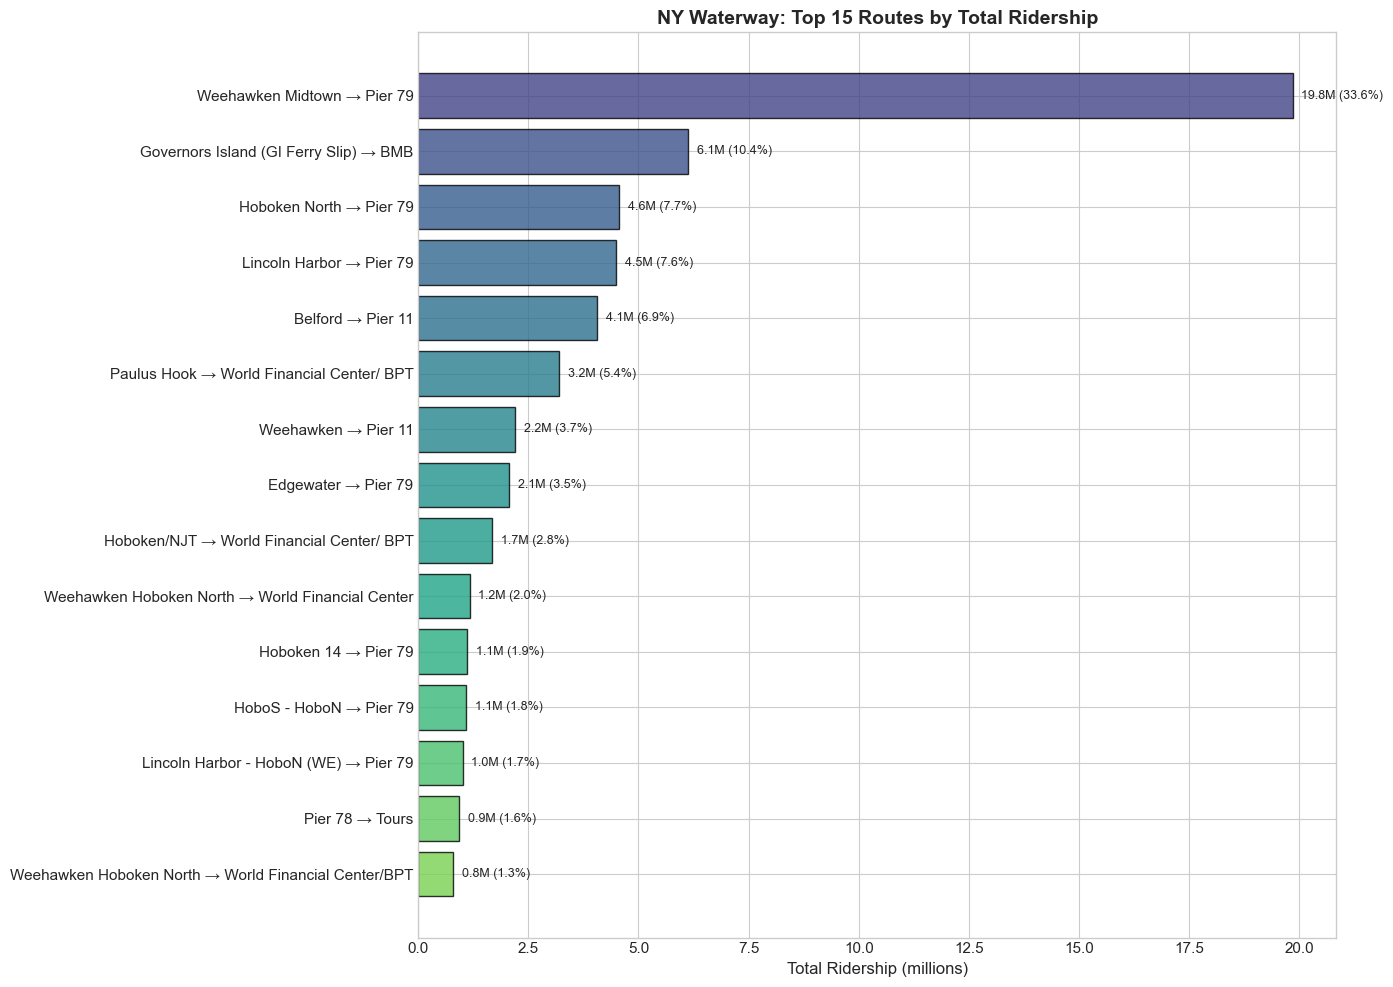


Top route (Weehawken Midtown → Pier 79) accounts for 33.6% of all NY Waterway ridership!


In [16]:
# Visualize top routes
fig, ax = plt.subplots(figsize=(14, 10))

top_routes = nyw_routes.head(15)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_routes)))
ax.barh(range(len(top_routes)), top_routes['total_ridership']/1e6, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_routes)))
ax.set_yticklabels(top_routes['route'])
ax.invert_yaxis()
ax.set_xlabel('Total Ridership (millions)', fontsize=12)
ax.set_title('NY Waterway: Top 15 Routes by Total Ridership', fontsize=14, fontweight='bold')

# Add value labels
for i, (val, pct) in enumerate(zip(top_routes['total_ridership'], top_routes['pct'])):
    ax.text(val/1e6 + 0.2, i, f'{val/1e6:.1f}M ({pct:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTop route (Weehawken Midtown → Pier 79) accounts for {nyw_routes.iloc[0]['pct']:.1f}% of all NY Waterway ridership!")

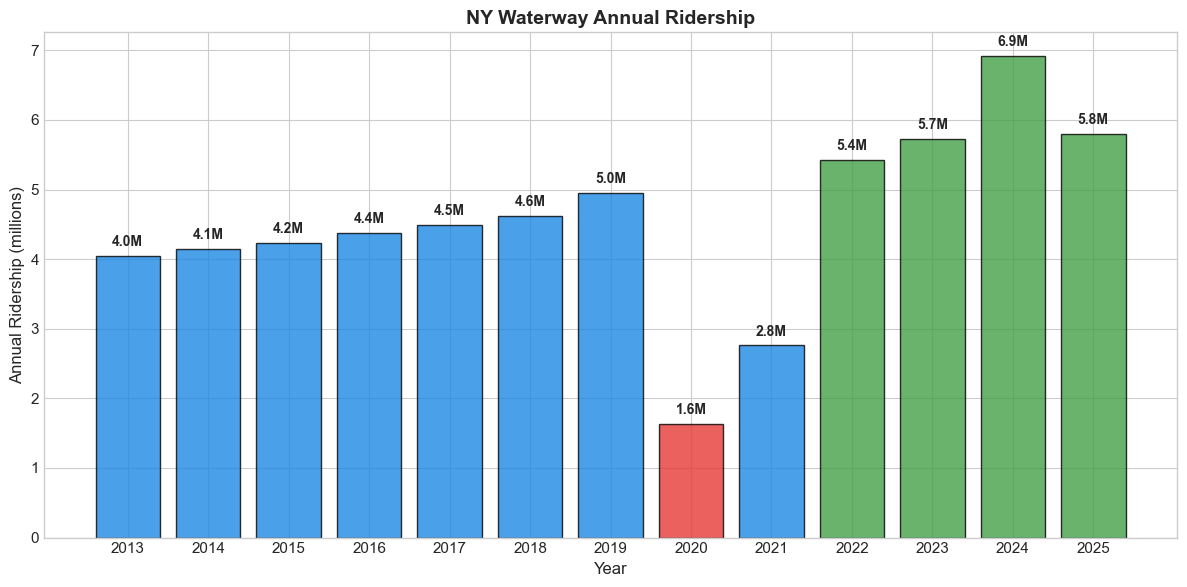


2019 ridership: 4,955,047
2025 ridership: 5,799,348
Recovery: 117.0% of 2019


In [17]:
# NY Waterway annual trend
nyw_yearly = nyw.groupby('year')['ridership'].sum()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#E53935' if y == 2020 else '#43A047' if y >= 2022 else '#1E88E5' for y in nyw_yearly.index]
bars = ax.bar(nyw_yearly.index, nyw_yearly.values/1e6, color=colors, edgecolor='black', alpha=0.8)

# Add value labels
for bar, val in zip(bars, nyw_yearly.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val/1e6:.1f}M', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual Ridership (millions)', fontsize=12)
ax.set_title('NY Waterway Annual Ridership', fontsize=14, fontweight='bold')
ax.set_xticks(nyw_yearly.index)

plt.tight_layout()
plt.show()

# Calculate growth
pre_covid = nyw_yearly[2019]
latest = nyw_yearly[nyw_yearly.index.max()]
print(f"\n2019 ridership: {pre_covid:,.0f}")
print(f"{nyw_yearly.index.max()} ridership: {latest:,.0f}")
print(f"Recovery: {latest/pre_covid*100:.1f}% of 2019")

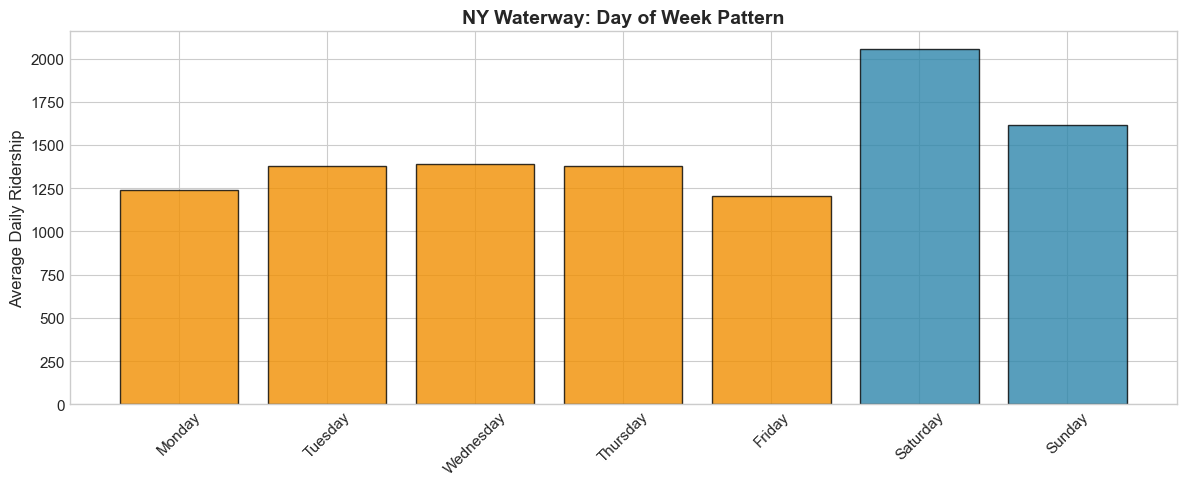


Weekday average: 1,318
Weekend average: 1,836
Weekend is 139.3% of weekday (strong commuter orientation)


In [18]:
# NY Waterway day of week pattern
nyw_dow = nyw.groupby('day_of_week')['ridership'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
nyw_dow = nyw_dow.reindex(day_order)

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#2E86AB' if d in ['Saturday', 'Sunday'] else '#F18F01' for d in day_order]
ax.bar(day_order, nyw_dow.values, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('Average Daily Ridership', fontsize=12)
ax.set_title('NY Waterway: Day of Week Pattern', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

weekday_avg = nyw_dow[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean()
weekend_avg = nyw_dow[['Saturday', 'Sunday']].mean()
print(f"\nWeekday average: {weekday_avg:,.0f}")
print(f"Weekend average: {weekend_avg:,.0f}")
print(f"Weekend is {weekend_avg/weekday_avg*100:.1f}% of weekday (strong commuter orientation)")

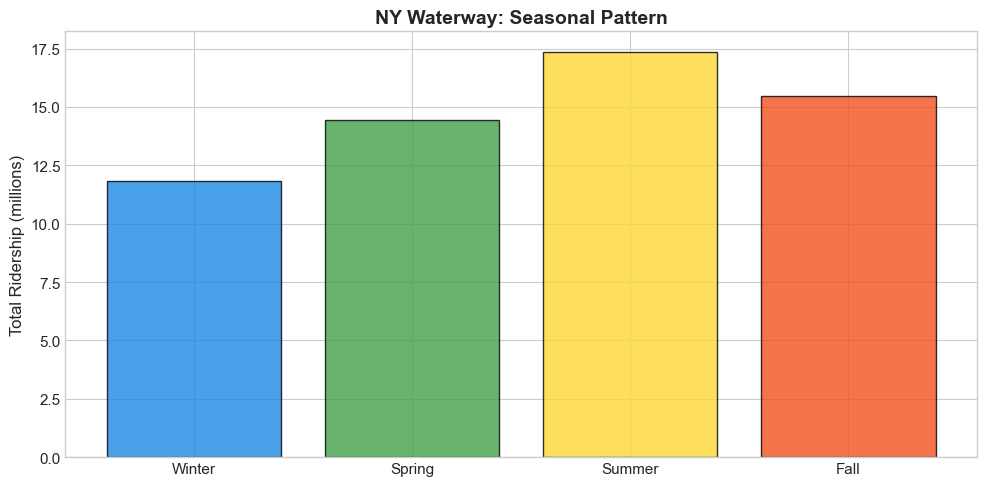


Unlike NYC Ferry (tourist-heavy), NY Waterway shows more consistent year-round ridership.
This reflects its commuter-focused service.


In [19]:
# NY Waterway seasonal pattern
nyw_season = nyw.groupby('season')['ridership'].sum()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
nyw_season = nyw_season.reindex(season_order)

season_colors = {'Winter': '#1E88E5', 'Spring': '#43A047', 'Summer': '#FDD835', 'Fall': '#F4511E'}

fig, ax = plt.subplots(figsize=(10, 5))
colors = [season_colors[s] for s in season_order]
ax.bar(season_order, nyw_season.values/1e6, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('Total Ridership (millions)', fontsize=12)
ax.set_title('NY Waterway: Seasonal Pattern', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nUnlike NYC Ferry (tourist-heavy), NY Waterway shows more consistent year-round ridership.")
print("This reflects its commuter-focused service.")

---

# Part 4: Cross-Hudson Commuter Analysis

Analyzing the NJ → Manhattan commuter ferry market.

In [20]:
# Define NJ origins for cross-Hudson analysis
nj_origins = [
    'Weehawken', 'Weehawken Midtown', 'Hoboken', 'Hoboken North', 'Hoboken 14', 'Hoboken/NJT',
    'Paulus Hook', 'Newport', 'Lincoln Harbor', 'Edgewater', 'Liberty Harbor', 'Port Liberte',
    'Belford', 'Atlantic Highlands', 'Highlands', 'Liberty Landing Ferry'
]

manhattan_dests = ['Pier 79', 'Pier 11', 'World Financial Center', 'World Financial Center/ BPT', 
                   'World Financial Center/BPT', 'Battery Park City', 'East 34th Street']

# Filter to cross-Hudson routes
cross_hudson = df_active[
    (df_active['origin'].str.contains('|'.join(nj_origins[:10]), case=False, na=False)) |
    (df_active['destination'].str.contains('Pier 79|Pier 11|World Financial|WFC', case=False, na=False))
].copy()

print("Cross-Hudson Commuter Market")
print("="*60)
print(f"Total records: {len(cross_hudson):,}")
print(f"Total ridership: {cross_hudson['ridership'].sum():,}")
print(f"Operators serving this market: {cross_hudson['operator'].unique()}")

Cross-Hudson Commuter Market
Total records: 75,691
Total ridership: 85,384,941
Operators serving this market: ['Billy Bey' 'Liberty Landing' 'Water Taxi' 'NY Waterway' 'SeaStreak'
 'HMS' 'Water Tours']


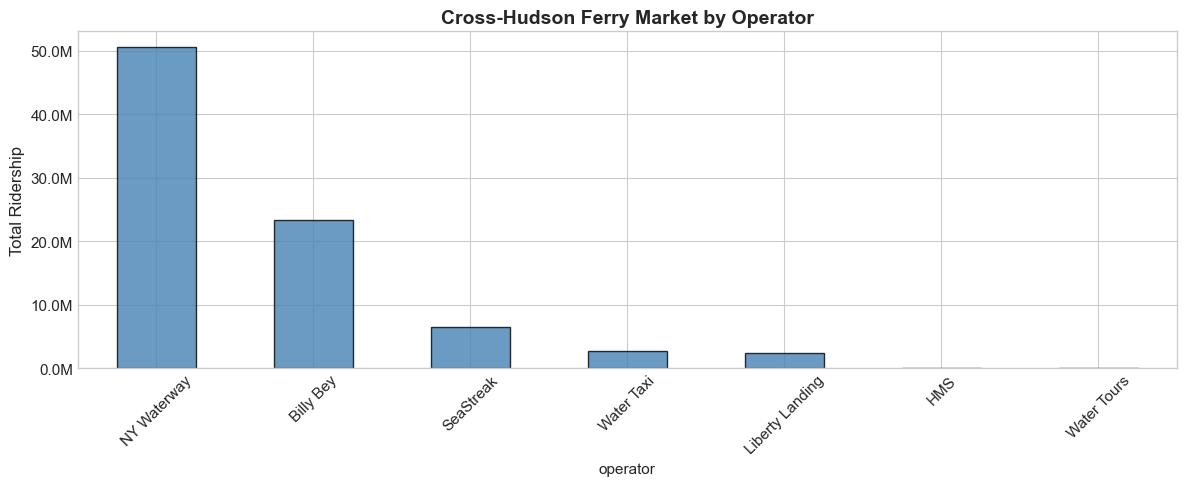

In [21]:
# Cross-Hudson by operator
ch_by_operator = cross_hudson.groupby('operator')['ridership'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
ch_by_operator.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_ylabel('Total Ridership', fontsize=12)
ax.set_title('Cross-Hudson Ferry Market by Operator', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [22]:
# Cross-Hudson routes - Sankey-style origin-destination matrix
ch_matrix = cross_hudson.groupby(['origin', 'destination'])['ridership'].sum().reset_index()
ch_matrix = ch_matrix.sort_values('ridership', ascending=False)

print("Top 20 Cross-Hudson Routes:")
ch_matrix['route'] = ch_matrix['origin'] + ' → ' + ch_matrix['destination']
ch_matrix['pct'] = (ch_matrix['ridership'] / ch_matrix['ridership'].sum() * 100).round(2)
ch_matrix[['route', 'ridership', 'pct']].head(20)

Top 20 Cross-Hudson Routes:


,route,ridership,pct
49,Weehawken Midtown → Pier 79,19847638,23.24
34,Paulus Hook → World Financial Center/ BPT,5895475,6.90
21,Hoboken North → Pier 79,4563033,5.34
27,Lincoln Harbor → Pier 79,4492669,5.26
2,Belford → Pier 11,4489153,5.26
14,Hoboken → Pier 11,4436661,5.20
33,Paulus Hook → World Financial Center,4368072,5.12
11,Highlands → Pier 11,3174359,3.72
31,Paulus Hook → Pier 11,2690463,3.15
16,Hoboken → World Financial Center,2551379,2.99


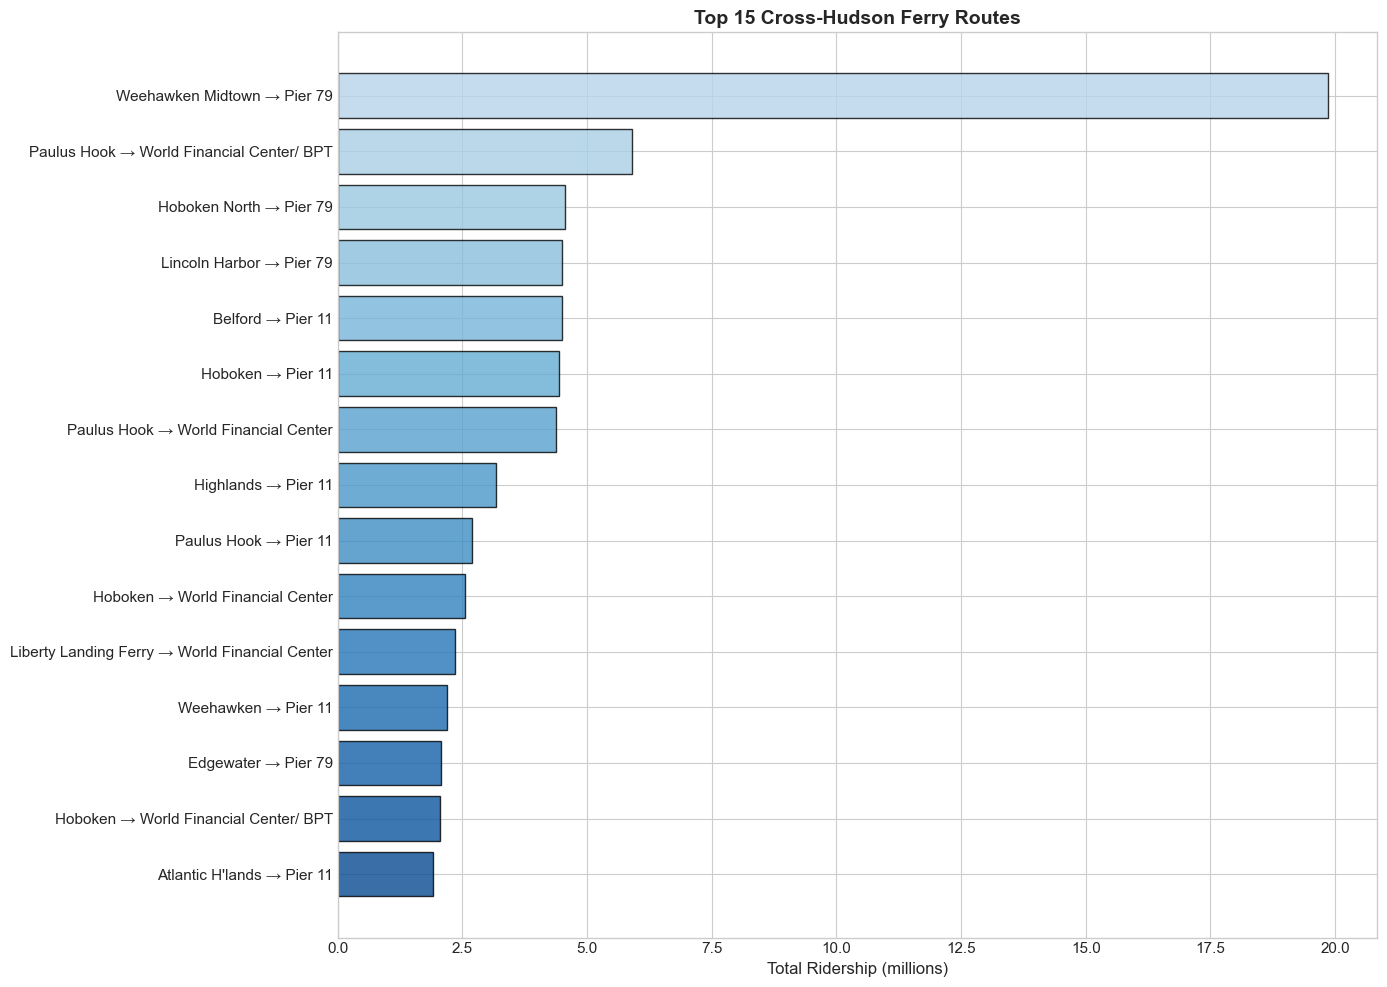

In [23]:
# Visualize top cross-Hudson routes
top_ch = ch_matrix.head(15)

fig, ax = plt.subplots(figsize=(14, 10))
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(top_ch)))
ax.barh(range(len(top_ch)), top_ch['ridership']/1e6, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_ch)))
ax.set_yticklabels(top_ch['route'])
ax.invert_yaxis()
ax.set_xlabel('Total Ridership (millions)', fontsize=12)
ax.set_title('Top 15 Cross-Hudson Ferry Routes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

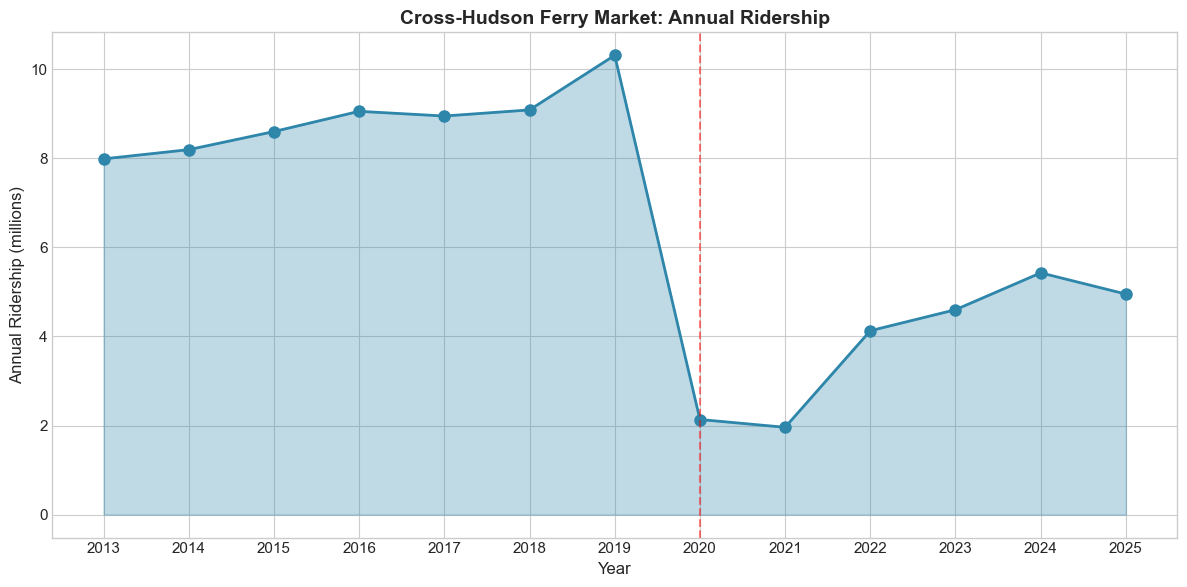

In [24]:
# Cross-Hudson annual trend
ch_yearly = cross_hudson.groupby('year')['ridership'].sum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ch_yearly.index, ch_yearly.values/1e6, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax.fill_between(ch_yearly.index, ch_yearly.values/1e6, alpha=0.3, color='#2E86AB')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual Ridership (millions)', fontsize=12)
ax.set_title('Cross-Hudson Ferry Market: Annual Ridership', fontsize=14, fontweight='bold')
ax.set_xticks(ch_yearly.index)

# Mark COVID
ax.axvline(x=2020, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

---

# Part 5: SeaStreak & Jersey Shore

Long-distance ferry commuting from the Jersey Shore to Manhattan.

In [25]:
# Filter to SeaStreak
seastreak = df_active[df_active['operator'] == 'SeaStreak'].copy()

print("SeaStreak Summary")
print("="*60)
print(f"Total ridership: {seastreak['ridership'].sum():,}")
print(f"Date range: {seastreak['date'].min().strftime('%Y-%m-%d')} to {seastreak['date'].max().strftime('%Y-%m-%d')}")
print(f"\nOrigins: {seastreak['origin'].unique()}")
print(f"\nDestinations: {seastreak['destination'].unique()}")

SeaStreak Summary
Total ridership: 12,440,169
Date range: 2013-01-02 to 2025-10-31

Origins: ["Atlantic H'lands" 'Highlands' 'Atlantic Highlands' 'Sandy Hook'
 'Belford' 'Brookfield Place' 'Paulus Hook' 'Bay Ridge' 'Staten Island']

Destinations: ['Pier 11' 'East 34th Street' 'BMB Slip #5' 'Pier 79' 'Belford'
 'Sandy Hook' 'Brookfield Place']


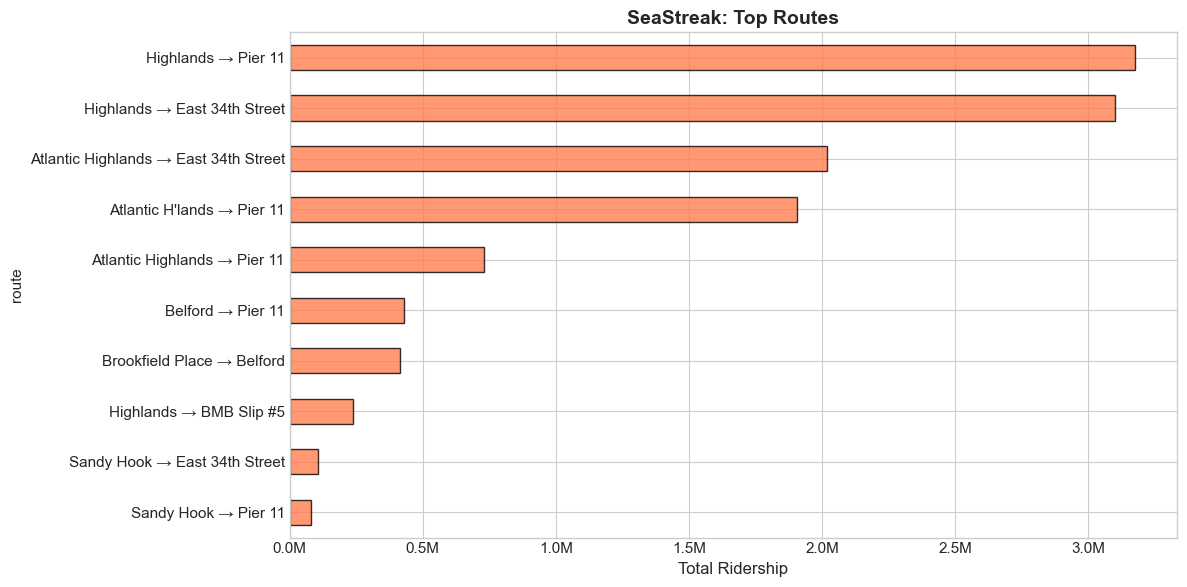


SeaStreak serves long-distance commuters from the Jersey Shore (Highlands, Atlantic Highlands, Belford).
These are some of the longest ferry commutes in the region (~40 miles).


In [26]:
# SeaStreak routes
ss_routes = seastreak.groupby('route')['ridership'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
ss_routes.head(10).plot(kind='barh', ax=ax, color='coral', edgecolor='black', alpha=0.8)
ax.invert_yaxis()
ax.set_xlabel('Total Ridership', fontsize=12)
ax.set_title('SeaStreak: Top Routes', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("\nSeaStreak serves long-distance commuters from the Jersey Shore (Highlands, Atlantic Highlands, Belford).")
print("These are some of the longest ferry commutes in the region (~40 miles).")

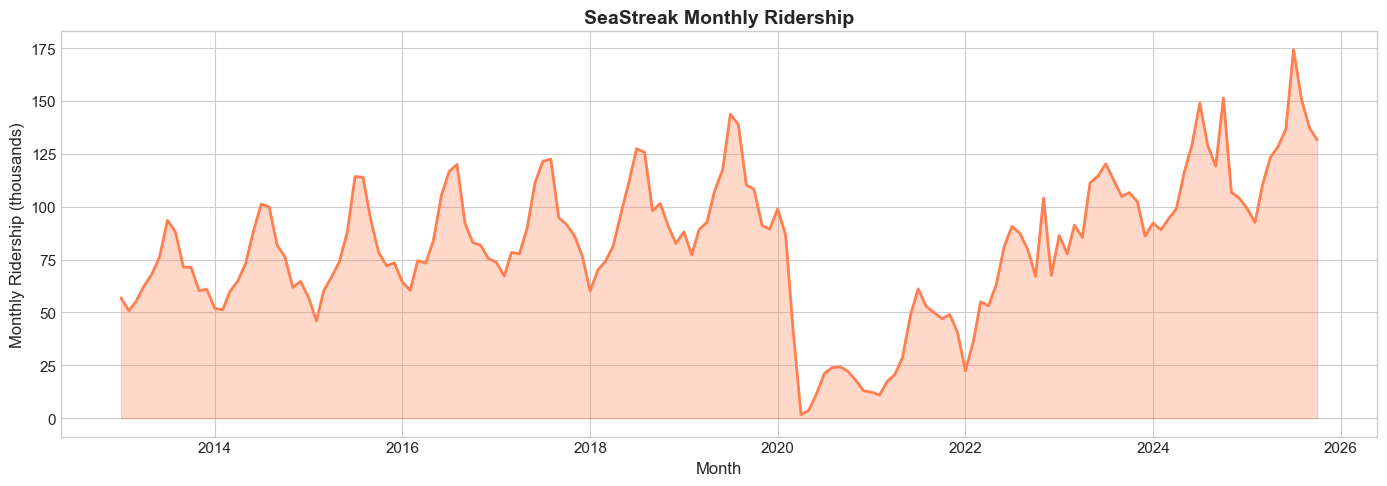

In [27]:
# SeaStreak seasonal pattern (should show beach season peaks)
ss_monthly = seastreak.groupby([seastreak['date'].dt.to_period('M')])['ridership'].sum()
ss_monthly.index = ss_monthly.index.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ss_monthly.index, ss_monthly.values/1e3, linewidth=2, color='coral')
ax.fill_between(ss_monthly.index, ss_monthly.values/1e3, alpha=0.3, color='coral')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Ridership (thousands)', fontsize=12)
ax.set_title('SeaStreak Monthly Ridership', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

---

# Part 6: Temporal Patterns

Analyzing ridership patterns across different time dimensions.

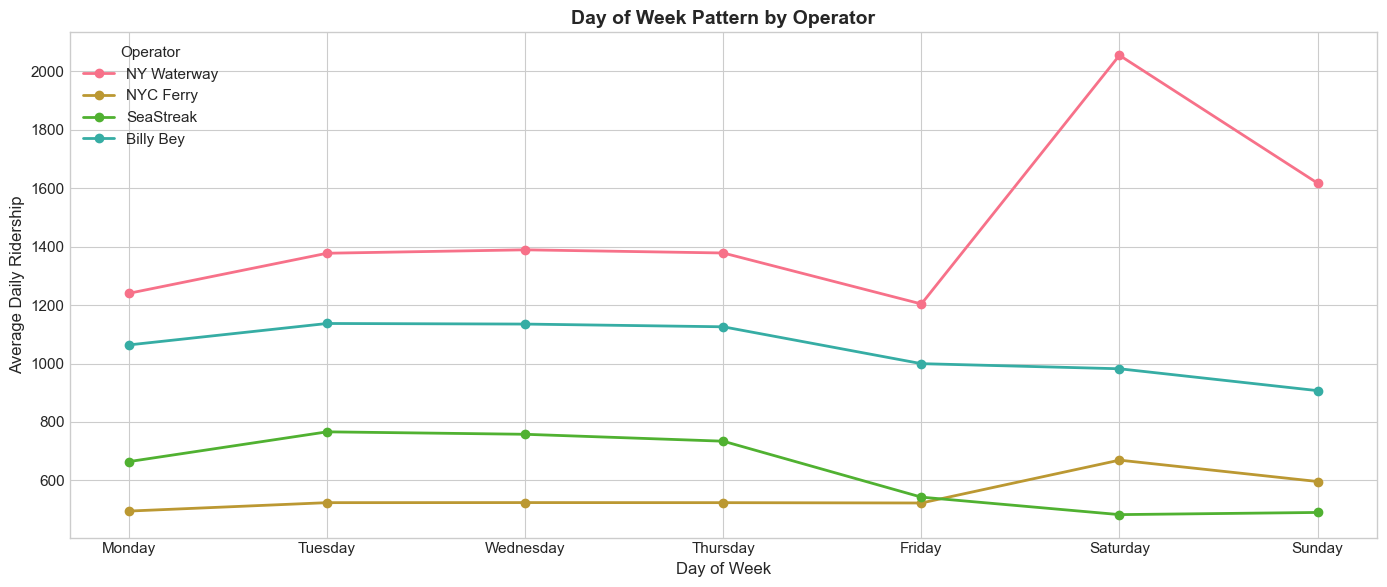


All operators show weekday peaks - ferry is primarily a commuter mode.
NYC Ferry has relatively higher weekend ridership (tourist component).


In [28]:
# Day of week pattern across all operators
dow_pattern = df_active.groupby(['operator', 'day_of_week'])['ridership'].mean().unstack()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pattern = dow_pattern[day_order]

fig, ax = plt.subplots(figsize=(14, 6))
dow_pattern.loc[['NY Waterway', 'NYC Ferry', 'SeaStreak', 'Billy Bey']].T.plot(ax=ax, marker='o', linewidth=2)
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Average Daily Ridership', fontsize=12)
ax.set_title('Day of Week Pattern by Operator', fontsize=14, fontweight='bold')
ax.legend(title='Operator')

plt.tight_layout()
plt.show()

print("\nAll operators show weekday peaks - ferry is primarily a commuter mode.")
print("NYC Ferry has relatively higher weekend ridership (tourist component).")

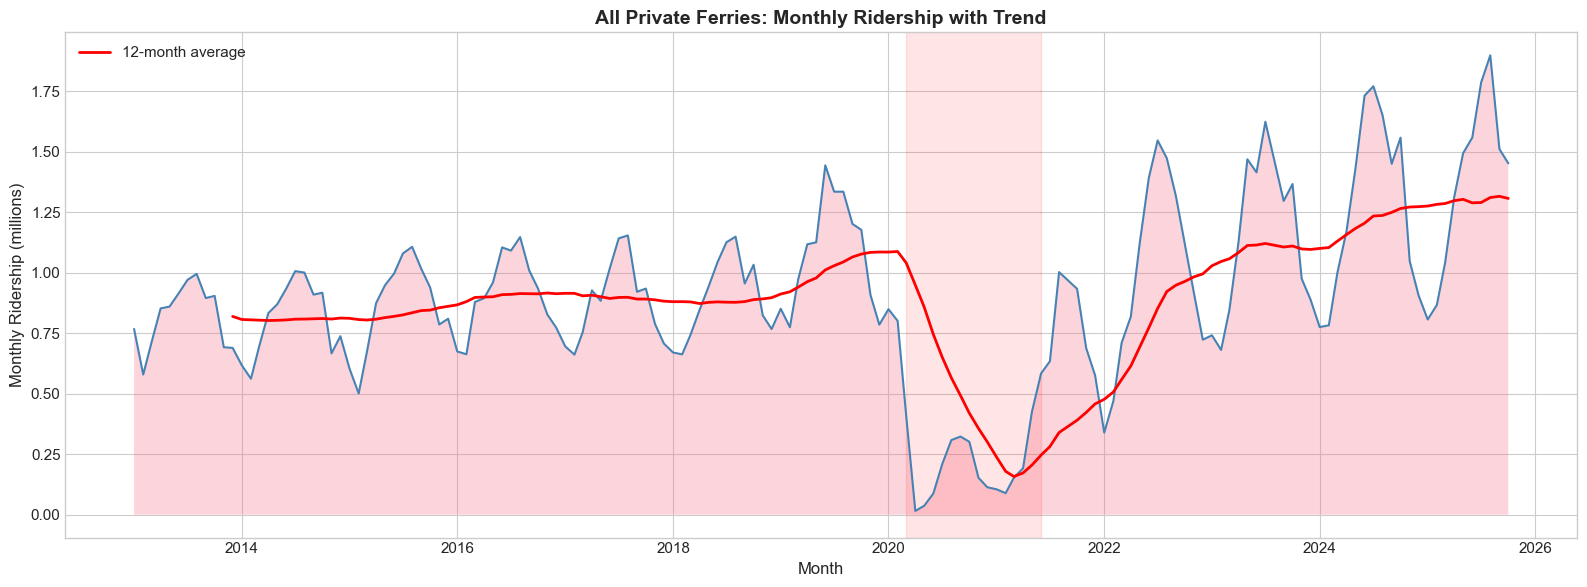

In [29]:
# Monthly pattern across years
monthly_all = df_active.groupby([df_active['date'].dt.to_period('M')])['ridership'].sum()
monthly_all.index = monthly_all.index.to_timestamp()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(monthly_all.index, monthly_all.values/1e6, linewidth=1.5, color='steelblue')
ax.fill_between(monthly_all.index, monthly_all.values/1e6, alpha=0.3)

# Add rolling average
rolling_avg = monthly_all.rolling(window=12).mean()
ax.plot(monthly_all.index, rolling_avg.values/1e6, linewidth=2, color='red', label='12-month average')

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Ridership (millions)', fontsize=12)
ax.set_title('All Private Ferries: Monthly Ridership with Trend', fontsize=14, fontweight='bold')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Mark COVID
ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), alpha=0.1, color='red')

plt.tight_layout()
plt.show()

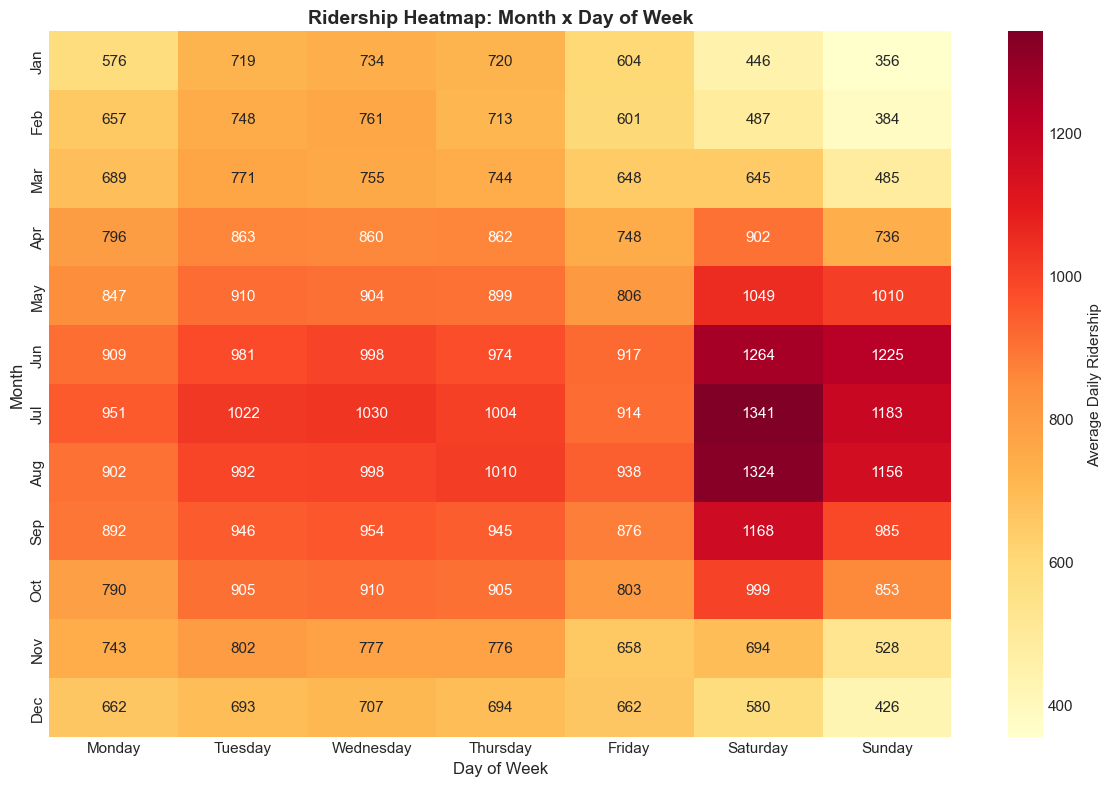

In [30]:
# Heatmap: Month x Day of Week
heatmap_data = df_active.groupby(['month', 'day_of_week'])['ridership'].mean().unstack()
heatmap_data = heatmap_data[day_order]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data.index = month_names

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', 
            cbar_kws={'label': 'Average Daily Ridership'}, ax=ax)
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Month', fontsize=12)
ax.set_title('Ridership Heatmap: Month x Day of Week', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [31]:
# Holiday impact
holiday_impact = df_active.groupby('is_holiday')['ridership'].agg(['mean', 'sum', 'count'])
holiday_impact.index = ['Regular Day', 'Holiday']

print("Holiday Impact on Ridership:")
print(holiday_impact)
print(f"\nHoliday ridership is {holiday_impact.loc['Holiday', 'mean'] / holiday_impact.loc['Regular Day', 'mean'] * 100:.1f}% of regular day")

Holiday Impact on Ridership:
                   mean        sum   count
Regular Day  836.736021  136567033  163214
Holiday      711.014103    1058700    1489

Holiday ridership is 85.0% of regular day


---

# Part 7: COVID Impact & Recovery

Analyzing pandemic effects on private ferry ridership.

In [32]:
# Define periods
pre_covid = df_active[df_active['date'] < '2020-03-01']
covid_period = df_active[(df_active['date'] >= '2020-03-01') & (df_active['date'] < '2021-07-01')]
recovery = df_active[df_active['date'] >= '2021-07-01']

print("COVID Impact Analysis")
print("="*60)
print(f"\nPre-COVID (before Mar 2020):")
print(f"  Records: {len(pre_covid):,}")
print(f"  Total ridership: {pre_covid['ridership'].sum():,}")
print(f"  Avg daily (per route): {pre_covid['ridership'].mean():,.0f}")

print(f"\nCOVID Period (Mar 2020 - Jun 2021):")
print(f"  Records: {len(covid_period):,}")
print(f"  Total ridership: {covid_period['ridership'].sum():,}")
print(f"  Avg daily (per route): {covid_period['ridership'].mean():,.0f}")

print(f"\nRecovery (Jul 2021 - Present):")
print(f"  Records: {len(recovery):,}")
print(f"  Total ridership: {recovery['ridership'].sum():,}")
print(f"  Avg daily (per route): {recovery['ridership'].mean():,.0f}")

COVID Impact Analysis

Pre-COVID (before Mar 2020):
  Records: 72,155
  Total ridership: 76,907,430
  Avg daily (per route): 1,066

COVID Period (Mar 2020 - Jun 2021):
  Records: 8,226
  Total ridership: 3,500,178
  Avg daily (per route): 426

Recovery (Jul 2021 - Present):
  Records: 84,322
  Total ridership: 57,218,125
  Avg daily (per route): 679


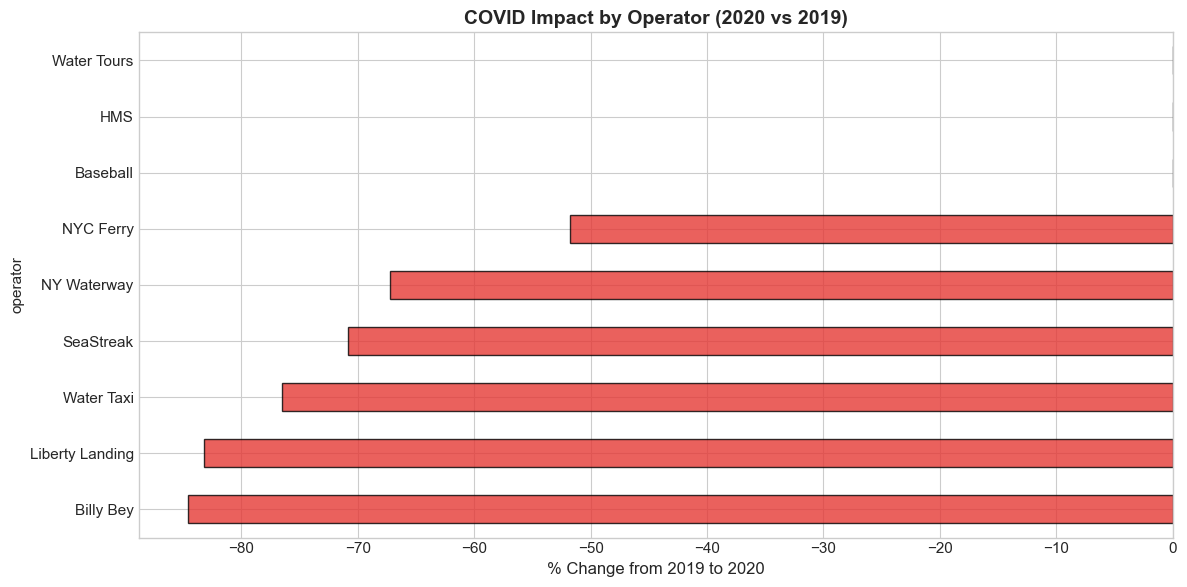

In [33]:
# Visualize COVID impact by operator
covid_by_op = df_active.groupby(['year', 'operator'])['ridership'].sum().unstack(fill_value=0)

# Calculate 2020 vs 2019 decline
decline_2020 = ((covid_by_op.loc[2020] - covid_by_op.loc[2019]) / covid_by_op.loc[2019] * 100).round(1)
decline_2020 = decline_2020[decline_2020 != 0].sort_values()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#E53935' if v < 0 else '#43A047' for v in decline_2020.values]
decline_2020.plot(kind='barh', ax=ax, color=colors, edgecolor='black', alpha=0.8)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('% Change from 2019 to 2020', fontsize=12)
ax.set_title('COVID Impact by Operator (2020 vs 2019)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

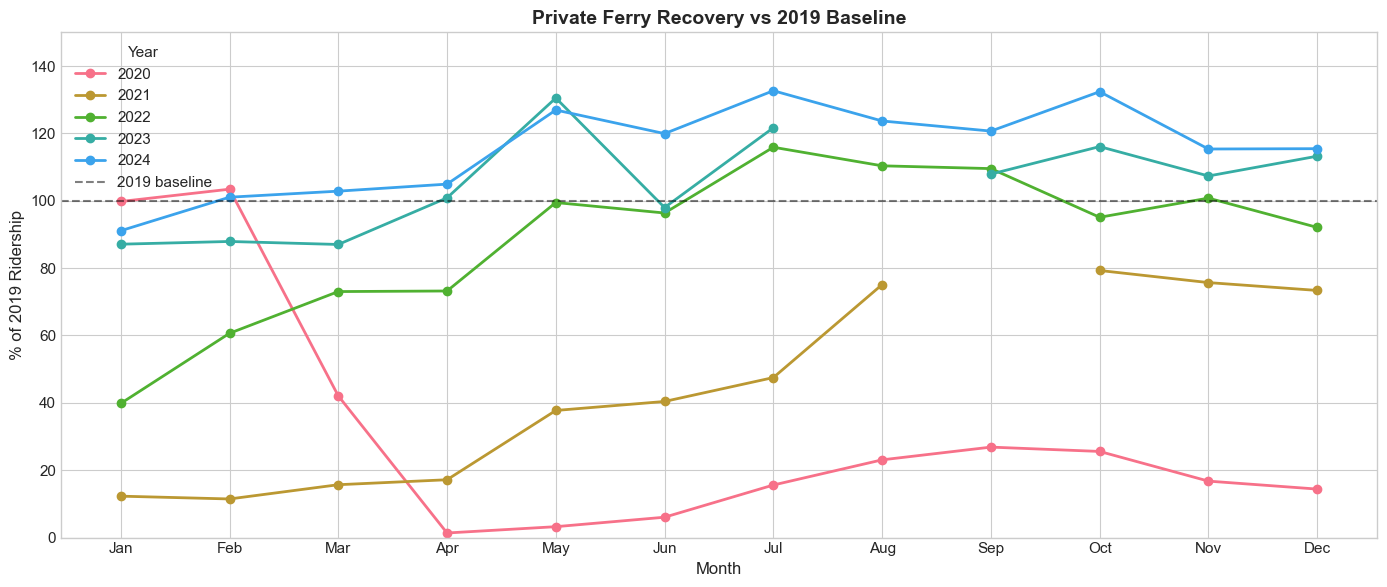

In [34]:
# Recovery trajectory
baseline_2019 = df_active[df_active['year'] == 2019].groupby('month')['ridership'].sum()
monthly_by_year = df_active.groupby(['year', 'month'])['ridership'].sum().unstack(level=0)

# Calculate recovery percentage
recovery_pct = monthly_by_year.div(baseline_2019, axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 6))
for year in [2020, 2021, 2022, 2023, 2024]:
    if year in recovery_pct.columns:
        ax.plot(recovery_pct.index, recovery_pct[year], marker='o', linewidth=2, label=str(year))

ax.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='2019 baseline')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('% of 2019 Ridership', fontsize=12)
ax.set_title('Private Ferry Recovery vs 2019 Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(title='Year')
ax.set_ylim(0, 150)

plt.tight_layout()
plt.show()

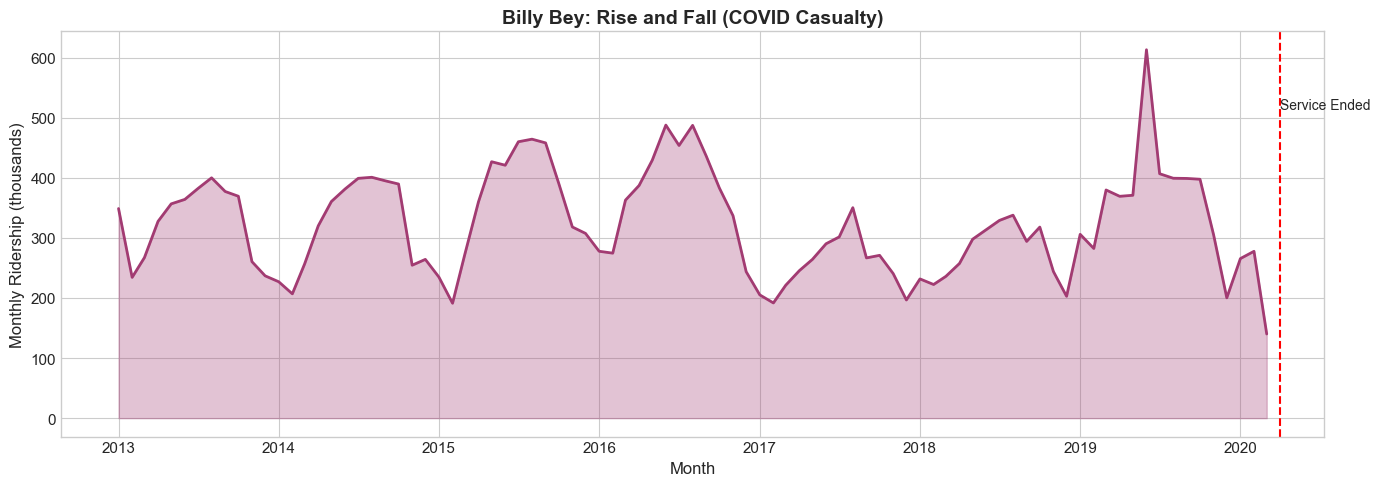


Billy Bey was the third-largest operator before COVID.
Service ended in April 2020 and never resumed.


In [35]:
# Billy Bey collapse (COVID casualty)
billy_bey = df_active[df_active['operator'] == 'Billy Bey']
bb_monthly = billy_bey.groupby(billy_bey['date'].dt.to_period('M'))['ridership'].sum()
bb_monthly.index = bb_monthly.index.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(bb_monthly.index, bb_monthly.values/1e3, linewidth=2, color='#A23B72')
ax.fill_between(bb_monthly.index, bb_monthly.values/1e3, alpha=0.3, color='#A23B72')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Ridership (thousands)', fontsize=12)
ax.set_title('Billy Bey: Rise and Fall (COVID Casualty)', fontsize=14, fontweight='bold')

# Mark end
ax.axvline(x=pd.Timestamp('2020-04-01'), color='red', linestyle='--')
ax.annotate('Service Ended', xy=(pd.Timestamp('2020-04-01'), ax.get_ylim()[1]*0.8), fontsize=10)

plt.tight_layout()
plt.show()

print("\nBilly Bey was the third-largest operator before COVID.")
print("Service ended in April 2020 and never resumed.")

---

# Part 8: Interactive Maps

Visualizing ferry terminal locations with basemaps.

In [36]:
# Define terminal coordinates (manually curated for key terminals)
terminal_coords = {
    # Manhattan terminals
    'Pier 79': (40.7603, -74.0041),
    'Pier 11': (40.7032, -74.0061),
    'World Financial Center': (40.7145, -74.0160),
    'World Financial Center/ BPT': (40.7145, -74.0160),
    'World Financial Center/BPT': (40.7145, -74.0160),
    'Battery Park City': (40.7150, -74.0178),
    'East 34th Street': (40.7439, -73.9707),
    'BMB': (40.6993, -74.0220),  # Brooklyn Maritime Building
    'Battery Maritime Building': (40.6993, -74.0220),
    
    # NJ terminals - Weehawken/Midtown
    'Weehawken': (40.7677, -74.0167),
    'Weehawken Midtown': (40.7677, -74.0167),
    'Lincoln Harbor': (40.7699, -74.0210),
    
    # NJ terminals - Hoboken area
    'Hoboken': (40.7360, -74.0280),
    'Hoboken North': (40.7399, -74.0240),
    'Hoboken 14': (40.7380, -74.0265),
    'Hoboken/NJT': (40.7350, -74.0290),
    
    # NJ terminals - Jersey City
    'Paulus Hook': (40.7140, -74.0340),
    'Newport': (40.7270, -74.0360),
    'Liberty Harbor': (40.7110, -74.0450),
    'Port Liberte': (40.6920, -74.0550),
    'Liberty Landing Ferry': (40.6920, -74.0550),
    
    # NJ terminals - Jersey Shore
    'Highlands': (40.4070, -73.9880),
    'Atlantic Highlands': (40.4140, -74.0340),
    'Belford': (40.4310, -74.0850),
    
    # Other
    'Edgewater': (40.8120, -73.9750),
    'Governors Island (GI Ferry Slip)': (40.6900, -74.0165),
}

print(f"Defined coordinates for {len(terminal_coords)} terminals")

Defined coordinates for 26 terminals


In [37]:
# Calculate ridership by terminal (origins)
origin_ridership = df_active.groupby('origin')['ridership'].sum().reset_index()
origin_ridership.columns = ['terminal', 'ridership']

# Add coordinates
origin_ridership['lat'] = origin_ridership['terminal'].map(lambda x: terminal_coords.get(x, (None, None))[0])
origin_ridership['lon'] = origin_ridership['terminal'].map(lambda x: terminal_coords.get(x, (None, None))[1])
origin_ridership = origin_ridership.dropna(subset=['lat', 'lon'])

print(f"Origins with coordinates: {len(origin_ridership)}")
origin_ridership.sort_values('ridership', ascending=False).head(10)

Origins with coordinates: 20


,terminal,ridership,lat,lon
84,Weehawken Midtown,19847638,40.7677,-74.0167
50,Paulus Hook,14177903,40.7140,-74.0340
36,Hoboken,9272039,40.7360,-74.0280
29,Governors Island (GI Ferry Slip),6839018,40.6900,-74.0165
34,Highlands,6512360,40.4070,-73.9880
38,Hoboken North,4563033,40.7399,-74.0240
8,Belford,4536469,40.4310,-74.0850
44,Lincoln Harbor,4492669,40.7699,-74.0210
5,Atlantic Highlands,2825437,40.4140,-74.0340
19,East 34th Street,2663301,40.7439,-73.9707


In [38]:
# Calculate ridership by terminal (destinations)
dest_ridership = df_active.groupby('destination')['ridership'].sum().reset_index()
dest_ridership.columns = ['terminal', 'ridership']

# Add coordinates
dest_ridership['lat'] = dest_ridership['terminal'].map(lambda x: terminal_coords.get(x, (None, None))[0])
dest_ridership['lon'] = dest_ridership['terminal'].map(lambda x: terminal_coords.get(x, (None, None))[1])
dest_ridership = dest_ridership.dropna(subset=['lat', 'lon'])

print(f"Destinations with coordinates: {len(dest_ridership)}")

Destinations with coordinates: 9


In [39]:
# Create map of NJ origin terminals
center_lat = 40.72
center_lon = -74.00

m_origins = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='CartoDB positron'
)

max_ridership = origin_ridership['ridership'].max()

for _, row in origin_ridership.iterrows():
    radius = 5 + (row['ridership'] / max_ridership) * 25
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color='darkblue',
        fill=True,
        fillColor='#1E88E5',
        fillOpacity=0.7,
        weight=2,
        popup=folium.Popup(
            f"<b>{row['terminal']}</b><br>"
            f"Total Ridership: {row['ridership']:,.0f}<br>"
            f"Share: {row['ridership']/origin_ridership['ridership'].sum()*100:.1f}%",
            max_width=250
        ),
        tooltip=row['terminal']
    ).add_to(m_origins)

# Add title
title_html = '''
<div style="position: fixed; top: 10px; left: 50px; width: 350px; 
            background-color: white; z-index:9999; padding: 10px; border-radius: 5px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
    <h4 style="margin: 0;">Private Ferry Origins (NJ Terminals)</h4>
    <p style="margin: 5px 0 0 0; font-size: 12px;">Circle size = total departing ridership</p>
</div>
'''
m_origins.get_root().html.add_child(folium.Element(title_html))

m_origins

In [40]:
# Create map of Manhattan destination terminals
m_dests = folium.Map(
    location=[40.72, -74.01],
    zoom_start=13,
    tiles='CartoDB positron'
)

max_ridership = dest_ridership['ridership'].max()

for _, row in dest_ridership.iterrows():
    radius = 8 + (row['ridership'] / max_ridership) * 30
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color='darkgreen',
        fill=True,
        fillColor='#43A047',
        fillOpacity=0.7,
        weight=2,
        popup=folium.Popup(
            f"<b>{row['terminal']}</b><br>"
            f"Total Ridership: {row['ridership']:,.0f}<br>"
            f"Share: {row['ridership']/dest_ridership['ridership'].sum()*100:.1f}%",
            max_width=250
        ),
        tooltip=row['terminal']
    ).add_to(m_dests)

# Add title
title_html = '''
<div style="position: fixed; top: 10px; left: 50px; width: 400px; 
            background-color: white; z-index:9999; padding: 10px; border-radius: 5px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
    <h4 style="margin: 0;">Private Ferry Destinations (Manhattan Terminals)</h4>
    <p style="margin: 5px 0 0 0; font-size: 12px;">Circle size = total arriving ridership</p>
</div>
'''
m_dests.get_root().html.add_child(folium.Element(title_html))

m_dests

In [41]:
# Combined map showing all terminals and routes
m_all = folium.Map(
    location=[40.72, -74.02],
    zoom_start=11,
    tiles='CartoDB dark_matter'
)

# Add origins (blue)
for _, row in origin_ridership.iterrows():
    radius = 5 + (row['ridership'] / origin_ridership['ridership'].max()) * 20
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color='#1E88E5',
        fill=True,
        fillColor='#1E88E5',
        fillOpacity=0.7,
        weight=1,
        popup=f"Origin: {row['terminal']}<br>Ridership: {row['ridership']:,.0f}",
        tooltip=f"Origin: {row['terminal']}"
    ).add_to(m_all)

# Add destinations (green)
for _, row in dest_ridership.iterrows():
    radius = 5 + (row['ridership'] / dest_ridership['ridership'].max()) * 20
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color='#43A047',
        fill=True,
        fillColor='#43A047',
        fillOpacity=0.7,
        weight=1,
        popup=f"Destination: {row['terminal']}<br>Ridership: {row['ridership']:,.0f}",
        tooltip=f"Dest: {row['terminal']}"
    ).add_to(m_all)

# Add lines for top routes
top_routes_data = df_active.groupby(['origin', 'destination'])['ridership'].sum().reset_index()
top_routes_data = top_routes_data.sort_values('ridership', ascending=False).head(10)

for _, row in top_routes_data.iterrows():
    origin_coord = terminal_coords.get(row['origin'])
    dest_coord = terminal_coords.get(row['destination'])
    
    if origin_coord and dest_coord:
        weight = 1 + (row['ridership'] / top_routes_data['ridership'].max()) * 5
        folium.PolyLine(
            locations=[origin_coord, dest_coord],
            weight=weight,
            color='#FFD700',
            opacity=0.6,
            popup=f"{row['origin']} → {row['destination']}<br>{row['ridership']:,.0f} riders"
        ).add_to(m_all)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 160px; 
            background-color: rgba(0,0,0,0.8); color: white; z-index:9999; 
            padding: 10px; border-radius: 5px;">
    <h5 style="margin: 0 0 10px 0;">Legend</h5>
    <div><span style="background:#1E88E5;padding:2px 8px;margin-right:5px;">&nbsp;</span>Origins (NJ)</div>
    <div><span style="background:#43A047;padding:2px 8px;margin-right:5px;">&nbsp;</span>Destinations</div>
    <div><span style="background:#FFD700;padding:2px 8px;margin-right:5px;">&nbsp;</span>Top Routes</div>
</div>
'''
m_all.get_root().html.add_child(folium.Element(legend_html))

# Add title
title_html = '''
<div style="position: fixed; top: 10px; left: 50px; width: 400px; 
            background-color: rgba(0,0,0,0.8); color: white; z-index:9999; 
            padding: 10px; border-radius: 5px;">
    <h4 style="margin: 0;">Cross-Hudson Ferry Network</h4>
    <p style="margin: 5px 0 0 0; font-size: 12px;">Blue = NJ origins, Green = Manhattan destinations, Yellow = Top routes</p>
</div>
'''
m_all.get_root().html.add_child(folium.Element(title_html))

m_all

---

# Part 9: Citi Bike Integration

Analyzing potential first/last mile connections between ferries and Citi Bike.

In [42]:
# Load Citi Bike station data
if CITIBIKE_STATIONS_PATH.exists():
    citibike = pd.read_csv(CITIBIKE_STATIONS_PATH)
    print(f"Loaded {len(citibike)} Citi Bike stations")
    print(f"Columns: {list(citibike.columns)}")
else:
    print("Citi Bike stations file not found")
    citibike = None

Loaded 2318 Citi Bike stations
Columns: ['station_id', 'short_name', 'name', 'lat', 'lon', 'capacity', 'region_id']


In [43]:
# Function to calculate distance between two points (Haversine formula)
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in meters."""
    R = 6371000  # Earth's radius in meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [44]:
# Find Citi Bike stations near Manhattan ferry terminals
if citibike is not None:
    RADIUS_M = 400  # 400 meters = ~5 min walk
    
    ferry_bike_connections = []
    
    # Manhattan terminals only (destinations for incoming ferries)
    manhattan_terminals = ['Pier 79', 'Pier 11', 'World Financial Center', 'Battery Park City', 'East 34th Street']
    
    for terminal in manhattan_terminals:
        if terminal in terminal_coords:
            t_lat, t_lon = terminal_coords[terminal]
            
            # Find ridership for this terminal
            terminal_total = dest_ridership[dest_ridership['terminal'] == terminal]['ridership'].sum()
            
            # Calculate distance to all Citi Bike stations
            distances = citibike.apply(
                lambda x: haversine_distance(t_lat, t_lon, x['lat'], x['lon']), axis=1
            )
            
            # Find stations within radius
            nearby = citibike[distances <= RADIUS_M].copy()
            nearby['ferry_terminal'] = terminal
            nearby['ferry_ridership'] = terminal_total
            nearby['distance_m'] = distances[distances <= RADIUS_M]
            
            if len(nearby) > 0:
                ferry_bike_connections.append(nearby)
    
    if ferry_bike_connections:
        connections_df = pd.concat(ferry_bike_connections, ignore_index=True)
        print(f"Found {len(connections_df)} Citi Bike stations within {RADIUS_M}m of Manhattan ferry terminals")
        print(f"Covering {connections_df['ferry_terminal'].nunique()} ferry terminals")
    else:
        connections_df = None

Found 16 Citi Bike stations within 400m of Manhattan ferry terminals
Covering 5 ferry terminals


In [45]:
# Summary of ferry-bike connections
if citibike is not None and connections_df is not None:
    connection_summary = connections_df.groupby('ferry_terminal').agg({
        'station_id': 'count',
        'distance_m': 'min',
        'ferry_ridership': 'first'
    }).reset_index()
    connection_summary.columns = ['ferry_terminal', 'nearby_bike_stations', 'closest_station_m', 'ferry_ridership']
    connection_summary = connection_summary.sort_values('ferry_ridership', ascending=False)
    
    print("\nManhattan Ferry Terminals with Citi Bike Access:")
    print(connection_summary.to_string(index=False))


Manhattan Ferry Terminals with Citi Bike Access:
        ferry_terminal  nearby_bike_stations  closest_station_m  ferry_ridership
               Pier 79                     1         128.493231         36573862
               Pier 11                     6          64.225738         25477424
World Financial Center                     4         105.354362         10427311
      East 34th Street                     3          55.854381          6252090
     Battery Park City                     2         109.192955                0


In [46]:
# Create multi-modal map
if citibike is not None and connections_df is not None:
    m_multimodal = folium.Map(
        location=[40.72, -74.01],
        zoom_start=13,
        tiles='CartoDB positron'
    )
    
    # Add ferry terminals (large markers)
    for terminal in manhattan_terminals:
        if terminal in terminal_coords:
            t_lat, t_lon = terminal_coords[terminal]
            ridership = dest_ridership[dest_ridership['terminal'] == terminal]['ridership'].sum()
            
            folium.CircleMarker(
                location=[t_lat, t_lon],
                radius=15,
                color='darkblue',
                fill=True,
                fillColor='#1E88E5',
                fillOpacity=0.8,
                weight=2,
                popup=f"<b>Ferry: {terminal}</b><br>Ridership: {ridership:,.0f}",
                tooltip=f"Ferry: {terminal}"
            ).add_to(m_multimodal)
    
    # Add connected Citi Bike stations (small markers)
    for _, row in connections_df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            color='green',
            fill=True,
            fillColor='#43A047',
            fillOpacity=0.7,
            weight=1,
            popup=f"<b>Citi Bike: {row['name']}</b><br>Near: {row['ferry_terminal']}<br>Distance: {row['distance_m']:.0f}m",
            tooltip=f"Bike: {row['name']}"
        ).add_to(m_multimodal)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; right: 50px; width: 200px; 
                background-color: white; z-index:9999; padding: 10px; border-radius: 5px;
                box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
        <h5 style="margin: 0 0 10px 0;">Multi-Modal Transit</h5>
        <div><span style="background:#1E88E5;border-radius:50%;display:inline-block;width:14px;height:14px;margin-right:5px;"></span>Ferry Terminal</div>
        <div><span style="background:#43A047;border-radius:50%;display:inline-block;width:10px;height:10px;margin-right:5px;"></span>Citi Bike (within 400m)</div>
    </div>
    '''
    m_multimodal.get_root().html.add_child(folium.Element(legend_html))
    
    # Add title
    title_html = '''
    <div style="position: fixed; top: 10px; left: 50px; width: 450px; 
                background-color: white; z-index:9999; padding: 10px; border-radius: 5px;
                box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
        <h4 style="margin: 0;">Ferry + Citi Bike Connections (Manhattan)</h4>
        <p style="margin: 5px 0 0 0; font-size: 12px;">Green dots = bike stations within 5-minute walk of ferry terminals</p>
    </div>
    '''
    m_multimodal.get_root().html.add_child(folium.Element(title_html))
    
    display(m_multimodal)
else:
    print("Cannot create multi-modal map without Citi Bike data.")

In [47]:
# Estimate potential multi-modal trips
if connections_df is not None:
    total_ferry_ridership = dest_ridership[dest_ridership['terminal'].isin(manhattan_terminals)]['ridership'].sum()
    
    print("\nMulti-Modal Potential Analysis")
    print("="*50)
    print(f"Ferry ridership at Manhattan terminals: {total_ferry_ridership:,.0f}")
    print(f"Citi Bike stations within walking distance: {len(connections_df)}")
    print(f"\nIf 10% of ferry riders connect via Citi Bike:")
    print(f"  Potential multi-modal trips: {total_ferry_ridership * 0.10:,.0f}")
    print(f"\nIf 25% of ferry riders connect via Citi Bike:")
    print(f"  Potential multi-modal trips: {total_ferry_ridership * 0.25:,.0f}")


Multi-Modal Potential Analysis
Ferry ridership at Manhattan terminals: 78,730,687
Citi Bike stations within walking distance: 16

If 10% of ferry riders connect via Citi Bike:
  Potential multi-modal trips: 7,873,069

If 25% of ferry riders connect via Citi Bike:
  Potential multi-modal trips: 19,682,672


---

# Part 10: NYC Ferry vs Private Operators

Comparing the public NYC Ferry system to private operators.

In [48]:
# Compare NYC Ferry vs Private operators
df_active['is_public'] = df_active['operator'] == 'NYC Ferry'

public_private = df_active.groupby('is_public').agg({
    'ridership': ['sum', 'mean', 'count'],
    'route': 'nunique'
}).round(1)
public_private.columns = ['total_ridership', 'avg_daily_route', 'records', 'unique_routes']
public_private.index = ['Private', 'NYC Ferry (Public)']

print("Public vs Private Ferry Comparison:")
public_private

Public vs Private Ferry Comparison:


,total_ridership,avg_daily_route,records,unique_routes
Private,107119593,978.7,109454,107
NYC Ferry (Public),30506140,552.2,55249,42


In [49]:
# Market share over time
market_share = df_active.groupby(['year', 'is_public'])['ridership'].sum().unstack(fill_value=0)
market_share.columns = ['Private', 'NYC Ferry']
market_share['Total'] = market_share.sum(axis=1)
market_share['NYC Ferry %'] = (market_share['NYC Ferry'] / market_share['Total'] * 100).round(1)
market_share['Private %'] = (market_share['Private'] / market_share['Total'] * 100).round(1)

print("\nMarket Share Over Time:")
market_share[['NYC Ferry %', 'Private %']]


Market Share Over Time:


,NYC Ferry %,Private %
year,,
2013,0.0,100.0
2014,0.0,100.0
2015,0.0,100.0
2016,0.0,100.0
2017,6.9,93.1
2018,10.2,89.8
2019,12.0,88.0
2020,21.0,79.0
2021,38.7,61.3


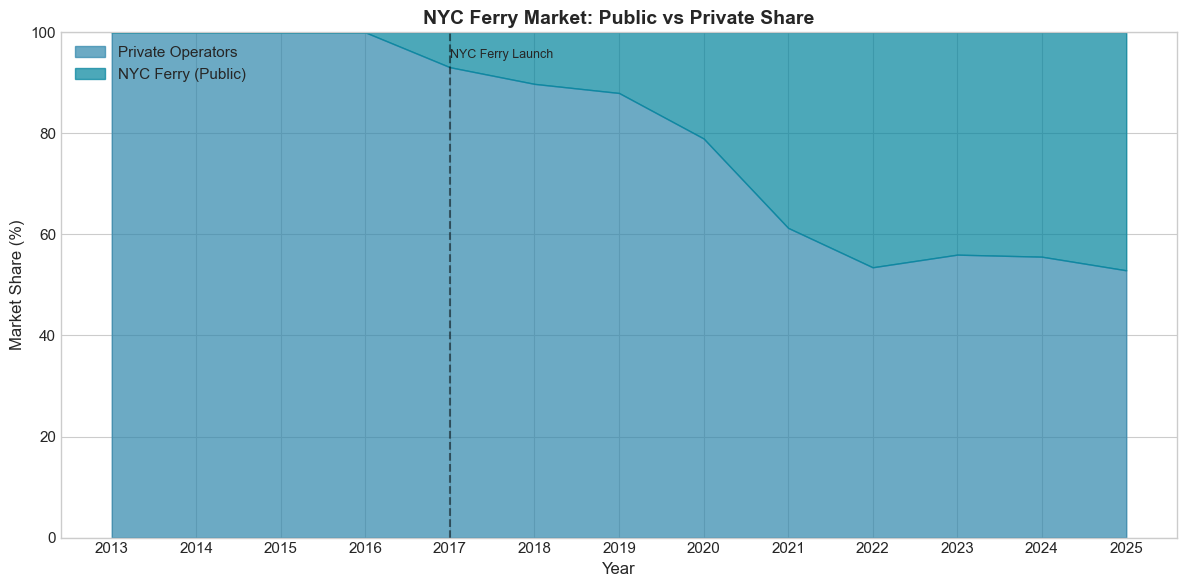


NYC Ferry grew from 0% (pre-2017) to 47.1% market share!


In [50]:
# Visualize market share evolution
fig, ax = plt.subplots(figsize=(12, 6))

years = market_share.index
ax.fill_between(years, 0, market_share['Private %'], label='Private Operators', alpha=0.7, color='#2E86AB')
ax.fill_between(years, market_share['Private %'], 100, label='NYC Ferry (Public)', alpha=0.7, color='#00839C')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Market Share (%)', fontsize=12)
ax.set_title('NYC Ferry Market: Public vs Private Share', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.set_ylim(0, 100)
ax.set_xticks(years)

# Mark NYC Ferry launch
ax.axvline(x=2017, color='black', linestyle='--', alpha=0.5)
ax.annotate('NYC Ferry Launch', xy=(2017, 95), fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nNYC Ferry grew from 0% (pre-2017) to {market_share.loc[market_share.index.max(), 'NYC Ferry %']:.1f}% market share!")

In [51]:
# Service area comparison
print("\nService Area Comparison:")
print("="*50)
print("\nNYC Ferry (Public):")
print("  - East River corridor (Brooklyn, Queens → Manhattan)")
print("  - Rockaway (beach access)")
print("  - St. George (Staten Island)")
print("  - Focus: Intra-NYC transit")

print("\nPrivate Operators (NY Waterway, SeaStreak):")
print("  - Cross-Hudson (NJ → Manhattan)")
print("  - Jersey Shore (Highlands, Atlantic Highlands)")
print("  - Focus: Inter-state commuting")

print("\nKey difference: NYC Ferry serves NYC residents,")
print("private ferries serve NJ commuters.")


Service Area Comparison:

NYC Ferry (Public):
  - East River corridor (Brooklyn, Queens → Manhattan)
  - Rockaway (beach access)
  - St. George (Staten Island)
  - Focus: Intra-NYC transit

Private Operators (NY Waterway, SeaStreak):
  - Cross-Hudson (NJ → Manhattan)
  - Jersey Shore (Highlands, Atlantic Highlands)
  - Focus: Inter-state commuting

Key difference: NYC Ferry serves NYC residents,
private ferries serve NJ commuters.


---

# Summary & Key Findings

In [52]:
# Generate summary
print("="*70)
print("PRIVATE FERRY & NY WATERWAY ANALYSIS - EXECUTIVE SUMMARY")
print("="*70)

print("\n1. MARKET OVERVIEW")
print("-"*50)
print(f"   Total ridership (2013-2025): {df_active['ridership'].sum():,}")
print(f"   Operators: {df_active['operator'].nunique()}")
print(f"   Active operators: {operator_summary[operator_summary['status']=='Active'].shape[0]}")

print("\n2. MARKET LEADERS")
print("-"*50)
for i, (op, row) in enumerate(operator_summary.head(3).iterrows()):
    print(f"   {i+1}. {op}: {row['total_ridership']/1e6:.1f}M ({row['market_share']:.1f}%)")

print("\n3. NY WATERWAY (LARGEST OPERATOR)")
print("-"*50)
print(f"   Total ridership: {nyw['ridership'].sum():,}")
print(f"   Top route: Weehawken Midtown → Pier 79")
print(f"   Service type: Cross-Hudson commuter")

print("\n4. COVID IMPACT")
print("-"*50)
print(f"   2020 decline: ~{abs(decline_2020.mean()):.0f}% average across operators")
print(f"   Billy Bey: Ceased operations (COVID casualty)")
print(f"   Recovery: Most operators exceeded 2019 levels by 2024")

print("\n5. CITI BIKE INTEGRATION POTENTIAL")
print("-"*50)
if connections_df is not None:
    print(f"   Bike stations near Manhattan terminals: {len(connections_df)}")
    print(f"   Potential multi-modal riders: 10-25% of ferry passengers")

print("\n" + "="*70)

PRIVATE FERRY & NY WATERWAY ANALYSIS - EXECUTIVE SUMMARY

1. MARKET OVERVIEW
--------------------------------------------------
   Total ridership (2013-2025): 137,625,733
   Operators: 9
   Active operators: 5

2. MARKET LEADERS
--------------------------------------------------
   1. NY Waterway: 59.1M (43.0%)
   2. NYC Ferry: 30.5M (22.2%)
   3. Billy Bey: 28.1M (20.4%)

3. NY WATERWAY (LARGEST OPERATOR)
--------------------------------------------------
   Total ridership: 59,117,204
   Top route: Weehawken Midtown → Pier 79
   Service type: Cross-Hudson commuter

4. COVID IMPACT
--------------------------------------------------
   2020 decline: ~72% average across operators
   Billy Bey: Ceased operations (COVID casualty)
   Recovery: Most operators exceeded 2019 levels by 2024

5. CITI BIKE INTEGRATION POTENTIAL
--------------------------------------------------
   Bike stations near Manhattan terminals: 16
   Potential multi-modal riders: 10-25% of ferry passengers



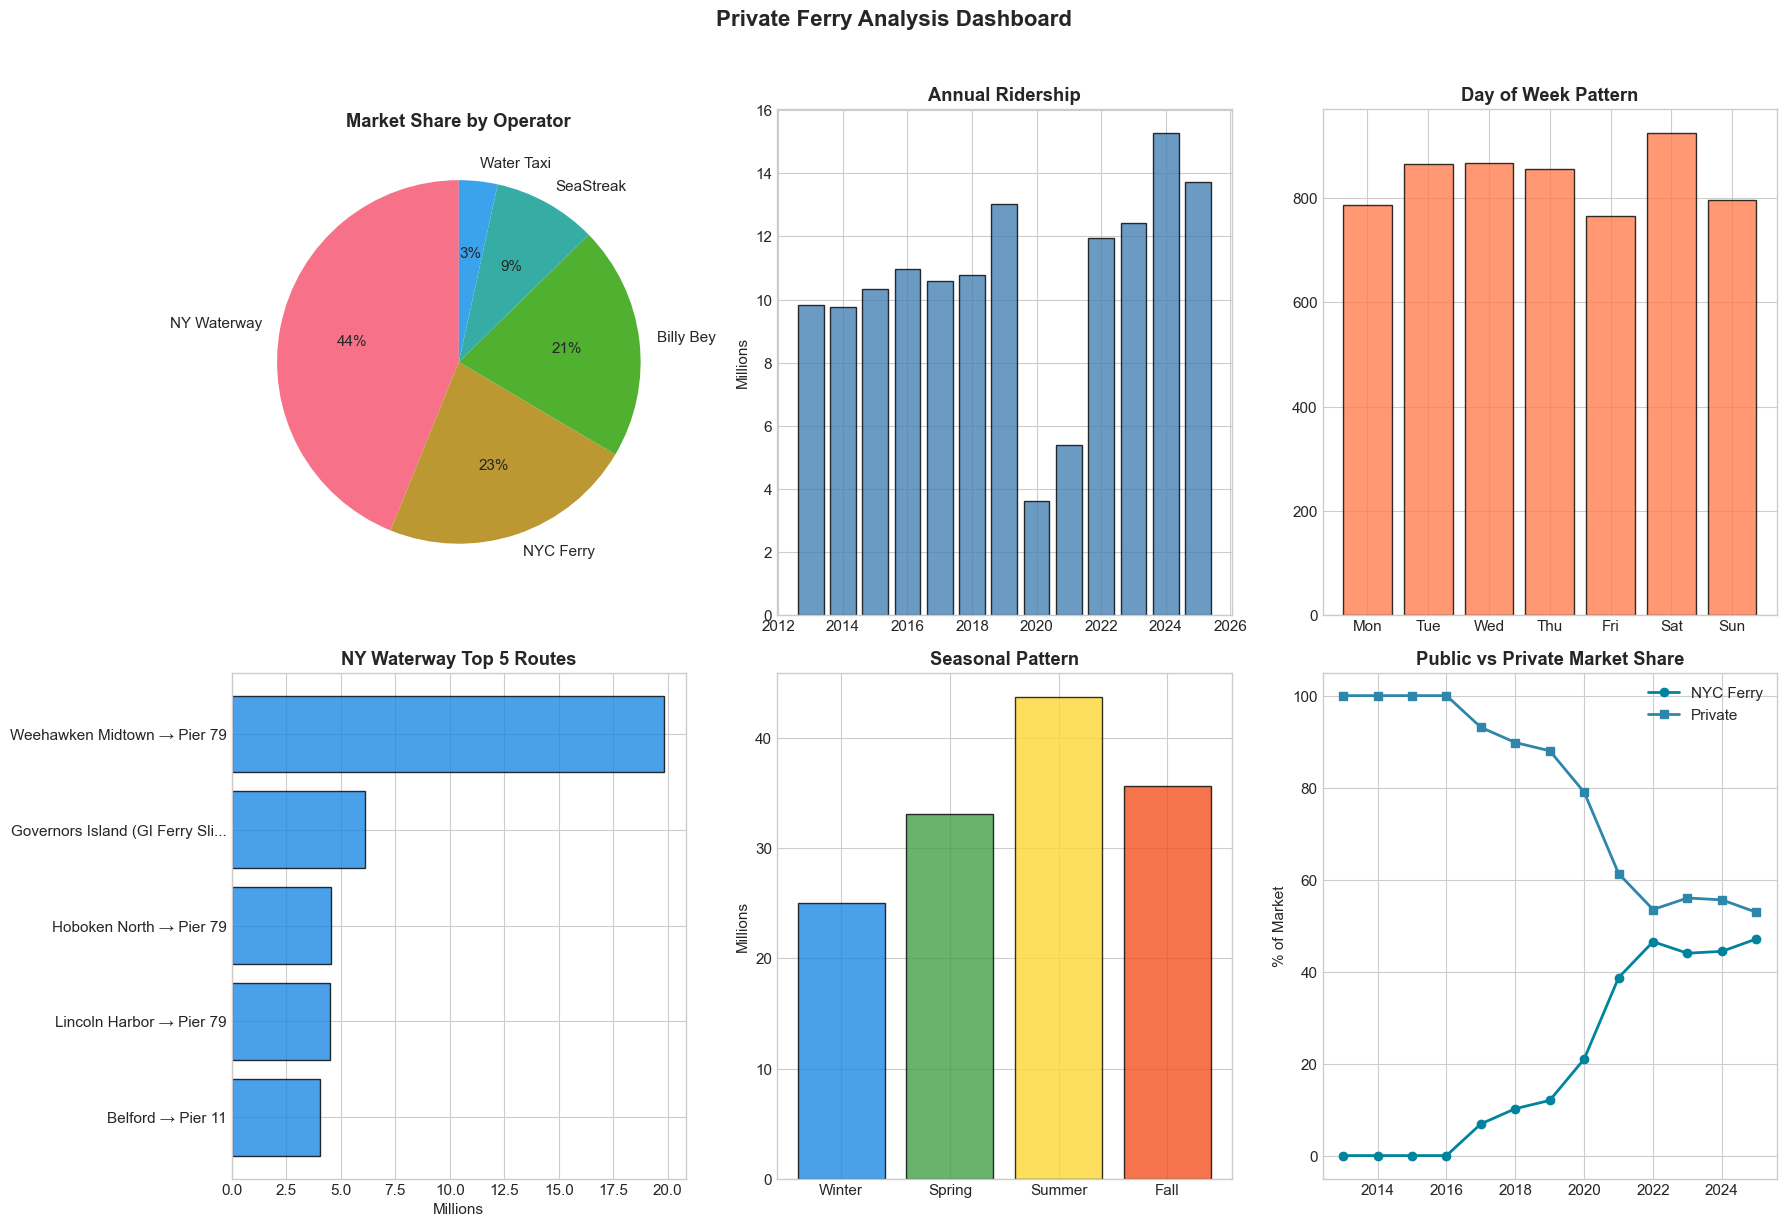

In [53]:
# Final summary visualization
fig = plt.figure(figsize=(18, 12))

# 1. Operator market share pie
ax1 = fig.add_subplot(2, 3, 1)
top_ops_pie = operator_summary[operator_summary['market_share'] >= 2]
ax1.pie(top_ops_pie['total_ridership'], labels=top_ops_pie.index, autopct='%1.0f%%', startangle=90)
ax1.set_title('Market Share by Operator', fontweight='bold')

# 2. Annual trend
ax2 = fig.add_subplot(2, 3, 2)
yearly_total = df_active.groupby('year')['ridership'].sum()
ax2.bar(yearly_total.index, yearly_total.values/1e6, color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_title('Annual Ridership', fontweight='bold')
ax2.set_ylabel('Millions')

# 3. Day of week
ax3 = fig.add_subplot(2, 3, 3)
dow_all = df_active.groupby('day_of_week')['ridership'].mean().reindex(day_order)
ax3.bar(range(7), dow_all.values, color='coral', edgecolor='black', alpha=0.8)
ax3.set_xticks(range(7))
ax3.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax3.set_title('Day of Week Pattern', fontweight='bold')

# 4. NY Waterway top routes
ax4 = fig.add_subplot(2, 3, 4)
nyw_top5 = nyw_routes.head(5)
ax4.barh(range(5), nyw_top5['total_ridership']/1e6, color='#1E88E5', edgecolor='black', alpha=0.8)
ax4.set_yticks(range(5))
ax4.set_yticklabels([r[:30]+'...' if len(r) > 30 else r for r in nyw_top5['route']])
ax4.invert_yaxis()
ax4.set_title('NY Waterway Top 5 Routes', fontweight='bold')
ax4.set_xlabel('Millions')

# 5. Seasonal pattern
ax5 = fig.add_subplot(2, 3, 5)
season_all = df_active.groupby('season')['ridership'].sum().reindex(season_order)
colors = [season_colors[s] for s in season_order]
ax5.bar(season_order, season_all.values/1e6, color=colors, edgecolor='black', alpha=0.8)
ax5.set_title('Seasonal Pattern', fontweight='bold')
ax5.set_ylabel('Millions')

# 6. Public vs Private trend
ax6 = fig.add_subplot(2, 3, 6)
ax6.plot(market_share.index, market_share['NYC Ferry %'], marker='o', linewidth=2, label='NYC Ferry', color='#00839C')
ax6.plot(market_share.index, market_share['Private %'], marker='s', linewidth=2, label='Private', color='#2E86AB')
ax6.set_title('Public vs Private Market Share', fontweight='bold')
ax6.set_ylabel('% of Market')
ax6.legend()

plt.suptitle('Private Ferry Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## Next Steps & Recommendations

1. **Time-of-day analysis**: Private ferry data lacks hourly granularity - consider supplementing with NYC Ferry hourly data
2. **Weather correlation**: Join with weather data to analyze ridership sensitivity
3. **Citi Bike trip matching**: Match actual Citi Bike trips near ferry terminals to quantify multi-modal usage
4. **Fare analysis**: Compare cost per trip across operators
5. **Service frequency**: Incorporate GTFS data to analyze trips per day

---

*Notebook created: December 2024*  
*Data source: NYC DOT Private Ferry Monthly Reports*